In [53]:
import argparse
import copy
import gzip
import heapq
import itertools
import os
import pickle
from collections import defaultdict
from itertools import count
import matplotlib.pyplot as plt

import numpy as np
from scipy.stats import norm
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import ipywidgets as widgets
from ipywidgets import interact


In [54]:
_dev = [torch.device('cpu')]
# tf = lambda x: torch.FloatTensor(x).to(_dev[0])
# tl = lambda x: torch.LongTensor(x).to(_dev[0])
tf = lambda x: torch.FloatTensor(np.array(x)).to(_dev[0])  # Convert to numpy array first
tl = lambda x: torch.LongTensor(np.array(x)).to(_dev[0])

def set_device(dev):
    _dev[0] = dev 

def func_corners(x):
    ax = abs(x)
    return (ax > 0.5).prod(-1) * 0.5 + ((ax < 0.8) * (ax > 0.6)).prod(-1) * 2 + 1e-1



# Define the sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Define the dynamical system for the n-node system with sigmoid
def node_system_with_sigmoid(x, t, coord):
    matrix_dim = len(x)
    M_tilde = np.reshape(coord, (matrix_dim, matrix_dim))
    z = M_tilde.dot(x)  # Compute M_tilde * x
    sigmoid_z = sigmoid(z)
    dxdt = sigmoid_z - x  # Compute the derivative   
    return dxdt

# Calculate reward given the weights
def reward_oscillator(coord, ndim):
    delta = 0.0001  # 0.0001
    matrix_dim = int(np.sqrt(ndim))
    x0 = np.linspace(0, 1, matrix_dim, endpoint=False)  # Initial conditions
    t = np.linspace(0, 20, 200)  # Define the time points
    sol = odeint(node_system_with_sigmoid, x0, t, args=(coord, ))
    
    # Calculate the total number of sharp peaks across all time series
    total_peaks = 0
    for i in range(matrix_dim):  # Loop through each time series x1, x2, ..., xn
        x_i = sol[:, i]
        dx_i = np.diff(x_i)  # First derivative approximation
        peaks = 0
        for j in range(1, len(dx_i)):
            if dx_i[j-1] > 0 and dx_i[j] < 0:  # Detect a peak
                sharpness = x_i[j] - (x_i[j-1] + x_i[j+1]) / 2
                if sharpness > delta:  # Check if the peak is sharp
                    peaks += 1
        total_peaks += peaks  # Add the number of sharp peaks for this time series
    
    if total_peaks == 0:
        return 2.5e-5  # see log_reg_c
    else:
        return 3 * 10**total_peaks  # 3*10^1, 3*10^2, ... for 1, 2, ... peaks
        # return min(total_peaks**5, 14**5)  # number of peaks   


In [55]:

class GridEnv:

    def __init__(self, horizon, ndim=2, multiplier=2, func=None):
        self.horizon = horizon
        self.ndim = ndim
        self.multiplier = multiplier
        self.func = func   # Sets the reward function.
        self._true_density = None
 
    def obs(self, s=None):
        """
        Returns a one-hot encoded observation of the current state.
        The observation is a flattened vector representing the agent's position in the grid.
        """
        s = np.int32(self._state if s is None else s)
        z = np.zeros((self.horizon * self.ndim), dtype=np.float32)
        z[np.arange(len(s)) * self.horizon + s] = 1 
        return z    # one-hot agent's current position in the grid.
    
    def s2x(self, s):
        """
        Transform the grid of indices (state s) to spherical coordinates and then calculate the cartesian coordinates
        (x_1, x_2, ..., x_n) for n dimensions.
        
        s[0]: radial distance (r)
        s[1:n-1]: polar angles (theta_1, theta_2, ..., theta_{n-2})
        s[n-1]: azimuthal angle (phi)
        
        multiplier: scalar value to multiply the state s (default is 1)
        """
        # Apply the multiplier to the state s
        s = s * self.multiplier
        
        # Initialize the radius (r) from the first component of the state vector
        r = s[0]
    
        # Initialize an array to hold the Cartesian coordinates
        x = np.zeros(self.ndim)
    
        # Constants or parameters (assuming self.horizon refers to the number of steps in the grid)
        horizon = self.horizon
        
        # Calculate the spherical to Cartesian conversion
        product = r
        for i in range(1, self.ndim):
            if i == self.ndim - 1:
                # The last angle (phi) ranges from 0 to 2π
                phi = s[i] * 2 * np.pi / horizon
                x[i - 1] = product * np.cos(phi)
                x[i] = product * np.sin(phi)
            else:
                # The other angles (theta) range from 0 to π
                theta = s[i] * np.pi / horizon
                x[i - 1] = product * np.sin(theta)
                product *= np.cos(theta)
    
        return x
    
    def reset(self):
        """
        Resets the environment to the initial state.
        """
        self._state = np.int32([0] * self.ndim)   # start position (0,0...)
        self._step = 0
        return self.obs(), self.func(self.s2x(self._state), self.ndim), self._state

    def parent_transitions(self, s, used_stop_action):
        """
        Determines the parent states and corresponding actions that could have led to the current state.
        
        Parameters:
        - s: The current state.
        - used_stop_action: A boolean indicating if the stop action was used.
        
        Returns:
        - A list of possible parent states (one-hot encoded).
        - A list of corresponding actions.
        """
        if used_stop_action:
            return [self.obs(s)], [self.ndim]
            
        parents = []
        actions = []
        for i in range(self.ndim):
            if s[i] > 0:
                sp = s.copy()  # s + 0
                sp[i] -= 1
                if sp.max() == self.horizon - 1:  # Can't have a terminal parent
                    continue
                parents.append(self.obs(sp))  # Generate observation for parent state
                actions.append(i)
        return parents, actions

    
    def step(self, a):
        """
        Updates the environment's state based on the action `a` and 
        returns the new observation, reward, done signal, and new state.
        """
        s = self._state.copy()
        if a < self.ndim:
            s[a] += 1
        
        done = s.max() >= self.horizon - 1 or a == self.ndim
        self._state = s  # Update the internal state
        self._step += 1  # Increment step counter
        
        return self.obs(), 0 if not done else self.func(self.s2x(s), self.ndim), done, s



class ReplayBuffer:
    def __init__(self, args, env):
        self.buf = []
        self.strat = args.replay_strategy
        self.sample_size = args.replay_sample_size
        self.bufsize = args.replay_buf_size
        self.env = env

    def add(self, x, r_x):
        if self.strat == 'top_k':
            if len(self.buf) < self.bufsize or r_x > self.buf[0][0]:
                self.buf = sorted(self.buf + [(r_x, x)])[-self.bufsize:]

    def sample(self):
        if not len(self.buf):
            return []
        idxs = np.random.randint(0, len(self.buf), self.sample_size)
        return sum([self.generate_backward(*self.buf[i]) for i in idxs], [])  # Samples from the buffer and generates trajectories backward.

    def generate_backward(self, r, s0):
        s = np.int8(s0)
        os0 = self.env.obs(s)
        # If s0 is a forced-terminal state, the the action that leads
        # to it is s0.argmax() which .parents finds, but if it isn't,
        # we must indicate that the agent ended the trajectory with
        # the stop action
        used_stop_action = s.max() < self.env.horizon - 1
        done = True
        # Now we work backward from that last transition
        traj = []
        while s.sum() > 0:
            parents, actions = self.env.parent_transitions(s, used_stop_action)
            # add the transition
            traj.append([tf(i) for i in (parents, actions, [r], [self.env.obs(s)], [done])])
            # Then randomly choose a parent state
            if not used_stop_action:
                i = np.random.randint(0, len(parents))
                a = actions[i]
                s[a] -= 1
            # Values for intermediary trajectory states:
            used_stop_action = False
            done = False
            r = 0
        return traj  # Generates a trajectory by working backward from a terminal state.

def make_mlp(l, act=nn.LeakyReLU(), tail=[]):
    return nn.Sequential(*(sum(
        [[nn.Linear(i, o)] + ([act] if n < len(l)-2 else [])
         for n, (i, o) in enumerate(zip(l, l[1:]))], []) + tail))
    
class FlowNetAgent:
    def __init__(self, args, envs):
        self.model = make_mlp([args.horizon * args.ndim] +
                              [args.n_hid] * args.n_layers +
                              [args.ndim+1])
        self.model.to(args.dev)
        self.target = copy.deepcopy(self.model)
        self.envs = envs
        self.ndim = args.ndim
        self.tau = args.bootstrap_tau
        self.replay = ReplayBuffer(args, envs[0])
        self.log_reg_c = args.log_reg_c
        
        # to store training data
        self.trn_all_losses = []
        self.trn_all_visited_done = []


    def parameters(self):
        return self.model.parameters()

    def sample_many(self, mbsize, all_visited_done):
        """Collects transition data from multiple parallel trajectories."""
        batch = []  # store transitions.
        batch += self.replay.sample()
        s = tf([i.reset()[0] for i in self.envs])
        done = [False] * mbsize
        while not all(done):
            # Note to self: this is ugly, ugly code
            with torch.no_grad():
                acts = Categorical(logits=self.model(s)).sample()   # Samples actions based on model's logits.
            step = [i.step(a) for i,a in zip([e for d, e in zip(done, self.envs) if not d], acts)]
            p_a = [self.envs[0].parent_transitions(sp_state, a == self.ndim)
                   for a, (sp, r, done, sp_state) in zip(acts, step)]
            batch += [[tf(i) for i in (p, a, [r], [sp], [d])]
                      for (p, a), (sp, r, d, _) in zip(p_a, step)]
            c = count(0)
            m = {j:next(c) for j in range(mbsize) if not done[j]}
            done = [bool(d or step[m[i]][2]) for i, d in enumerate(done)]
            s = tf([i[0] for i in step if not i[2]])
            for (_, r, d, sp) in step:
                if d:
                    all_visited_done.append((tuple(sp), r))  # (state, reward) pairs
                    self.replay.add(tuple(sp), r) 
        return batch  # it returns a batch of collected transitions for training. {parents, actions, reward, next_state, done}

    def sample_one_traj(self):
        """
        Samples a single trajectory and returns it.
        """
        traj = []
        env = self.envs[0]
        traj.append([[], [], 0, np.int32([0] * self.ndim), False])
        
        s = tf(env.reset()[0])
        done = False
        while not done:
            with torch.no_grad():
                logits = self.model(s.unsqueeze(0))
                action_dist = Categorical(logits=logits)
                a = action_dist.sample().item()
            sp, r, done_flag, sp_state = env.step(a)
            parent_states, parent_actions = env.parent_transitions(sp_state, a == self.ndim)
            traj.append([parent_states, parent_actions, r, sp_state, done_flag])
            
            s = tf(sp)
            done = done_flag
        return traj

    def learn_from(self, it, batch):
        loginf = tf([1000])
        batch_idxs = tl(sum([[i]*len(parents) for i, (parents,_,_,_,_) in enumerate(batch)], []))
        parents, actions, r, sp, done = map(torch.cat, zip(*batch))
        parents_Qsa = self.model(parents)[torch.arange(parents.shape[0]), actions.long()]
        in_flow = torch.log(self.log_reg_c + torch.zeros((sp.shape[0],))
                            .index_add_(0, batch_idxs, torch.exp(parents_Qsa)))
        if self.tau > 0:
            with torch.no_grad(): next_q = self.target(sp)
        else:
            next_q = self.model(sp)
        next_qd = next_q * (1-done).unsqueeze(1) + done.unsqueeze(1) * (-loginf)
        out_flow = torch.logsumexp(torch.cat([torch.log(self.log_reg_c + r)[:, None], next_qd], 1), 1)
        
        term_loss = ((in_flow - out_flow) * done).pow(2).sum() / (done.sum() + 1e-20)
        flow_loss = ((in_flow - out_flow) * (1-done)).pow(2).sum() / ((1-done).sum() + 1e-20)
        
        # loss = (in_flow - out_flow).pow(2).mean()
        leaf_coef = 10
        loss = term_loss * leaf_coef + flow_loss

        if self.tau > 0:
            for a,b in zip(self.model.parameters(), self.target.parameters()):
                b.data.mul_(1-self.tau).add_(self.tau*a)

        return loss, term_loss, flow_loss    




In [56]:
# Training 

def make_opt(params, args):
    params = list(params)
    if not len(params):
        return None
    if args.opt == 'adam':
        opt = torch.optim.Adam(params, args.learning_rate,
                               betas=(args.adam_beta1, args.adam_beta2))
    elif args.opt == 'msgd':
        opt = torch.optim.SGD(params, args.learning_rate, momentum=args.momentum)
    return opt

def compute_empirical_reward_distribution(visited):
    if not len(visited):
        return {}
    reward_hist = defaultdict(int)
    for _, reward in visited:
        reward_hist[reward] += 1
    total_visits = sum(reward_hist.values())
    empirical_distribution = {reward: count / total_visits for reward, count in reward_hist.items()}
    return empirical_distribution



all_losses = []
all_visited_done = []

def main(args):
    args.dev = torch.device(args.device)
    set_device(args.dev)
    f = {'default': None,
         'corners': func_corners,
         'oscillator': reward_oscillator,
    }[args.func]
    
    env = GridEnv(args.horizon, args.ndim, multiplier=args.multiplier, func=f)
    envs = [GridEnv(args.horizon, args.ndim, multiplier=args.multiplier, func=f)
            for i in range(args.mbsize)] 
    ndim = args.ndim
    nnode = args.nnode

    if args.method == 'flownet':
        agent = FlowNetAgent(args, envs)
    elif args.method == 'mcmc':
        agent = MHAgent(args, envs)
    elif args.method == 'random_traj':
        agent = RandomTrajAgent(args, envs)

    opt = make_opt(agent.parameters(), args)

        
    
    # Log file setup
    root = args.save_path 
    log_file_path = os.path.join(root, f'trn-out-{args.nnode}-node.log')
    os.makedirs(os.path.dirname(log_file_path), exist_ok=True)
    with open(log_file_path, 'w') as log_file:
    
        # Training Loop Setup
        
        ttsr = max(int(args.train_to_sample_ratio), 1) # train to sample ratio
        sttr = max(int(1/args.train_to_sample_ratio), 1) # sample to train ratio
        
        for i in tqdm(range(args.n_train_steps+1), disable=not args.progress):
            data = []  # a list of transitions from a batch of trajectories
            for j in range(sttr):
                """Agent samples trajectories for training."""
                data += agent.sample_many(args.mbsize, all_visited_done)   
            for j in range(ttsr):
                """Agent updates its model using the sampled data."""
                losses = agent.learn_from(i * ttsr + j, data) # returns (opt loss, *metrics)
                if losses is not None:
                    losses[0].backward(retain_graph=(not i % 50))
                    if args.clip_grad_norm > 0:
                        torch.nn.utils.clip_grad_norm_(agent.parameters(),
                                                       args.clip_grad_norm)
                    opt.step()
                    opt.zero_grad()
                    all_losses.append([i.item() for i in losses])
        
            # Log empirical reward every 100 iterations
            if not i % 100:
                empirical_distribution = compute_empirical_reward_distribution(all_visited_done[-args.num_empirical_loss:])
                print('Partial Empirical Reward Distribution:', empirical_distribution)
                log_file.write(f'Partial Empirical Reward Distribution: {empirical_distribution}\n')
                log_file.flush()  # Ensure data is written to the log file
                        
            # Save the agent and model every 1000 iterations
            if not i % 1000:
                # Update agent with current all_losses and all_visited_done
                agent.trn_all_losses = all_losses.copy()
                agent.trn_all_visited_done = all_visited_done.copy()
                
                # Save the entire agent
                agent_save_path = os.path.join(root, f"agent_checkpoint_{i}.pkl.gz")  
                with gzip.open(agent_save_path, 'wb') as f: 
                    pickle.dump(agent, f)
                print(f"Agent checkpoint saved at iteration {i} in {nnode}.")
                log_file.write(f"Agent checkpoint saved at iteration {i} in {nnode}.\n")
                log_file.flush() 
            
                # Save the agent's model separately
                model_save_path = os.path.join(root, f"model_checkpoint_{i}.pkl.gz") 
                with gzip.open(model_save_path, 'wb') as f:  
                    pickle.dump(agent.model, f)
                print(f"Model checkpoint saved at iteration {i} in {nnode}.")
                log_file.write(f"Model checkpoint saved at iteration {i} in {nnode}.\n")
                log_file.flush() 


In [57]:
class Args:
    save_path = 'results-v3/5-node-v3'
    device = 'cpu'
    progress = True  
    method = 'flownet'
    learning_rate = 5e-4
    opt = 'adam'
    adam_beta1 = 0.9
    adam_beta2 = 0.999
    momentum = 0.9  # SGD with momentum
    mbsize = 8  # number of parallel environments (trajectories) are collected by one agent (One Agent's model is shared in Many Environments). 
    train_to_sample_ratio = 1.0  # determines how many times the agent should update its model (train) for each set of data it collects from the environment. 
    clip_grad_norm = 0.
    n_hid = 256  # number of hidden units in each hidden layer
    n_layers = 3
    n_train_steps = 30000 
    num_empirical_loss = 200000  # number of samples used to compute the empirical distribution loss during evaluation.
    
    
    # Env
    func = 'oscillator'
    horizon = 12  # 4*3
    nnode = 5
    ndim = nnode*nnode 
    multiplier = 2
    
    # Flownet
    bootstrap_tau = 0.0  # no bootstrapping,target network isn't being updated gradually but possibly replaced entirely at some point.
    replay_strategy = 'top_k'  # 'top_k' or 'none'
    replay_sample_size = 5  # number of experiences to sample from the replay buffer at each update step.
    replay_buf_size = 100  #  size of the replay buffer, which stores past experiences for the agent to learn from.
    log_reg_c = 2.5e-5



args = Args()
torch.set_num_threads(200)
main(args)



  0%|          | 1/30001 [00:00<1:45:00,  4.76it/s]

Partial Empirical Reward Distribution: {2.5e-05: 1.0}
Agent checkpoint saved at iteration 0 in 5.
Model checkpoint saved at iteration 0 in 5.


  0%|          | 101/30001 [00:36<2:11:59,  3.78it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9047029702970297, 30: 0.09282178217821782, 300: 0.0024752475247524753}


  1%|          | 201/30001 [01:11<3:34:17,  2.32it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.8606965174129353, 30: 0.1287313432835821, 300: 0.010572139303482588}


  1%|          | 301/30001 [01:46<2:01:36,  4.07it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.8662790697674418, 30: 0.12333887043189369, 300: 0.010382059800664452}


  1%|▏         | 401/30001 [02:15<2:25:12,  3.40it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.8631546134663342, 30: 0.12562344139650872, 300: 0.010910224438902744, 3000: 0.0003117206982543641}


  2%|▏         | 501/30001 [02:47<3:34:13,  2.30it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.8537924151696606, 30: 0.13273453093812376, 300: 0.012974051896207584, 3000: 0.000499001996007984}


  2%|▏         | 601/30001 [03:20<2:37:35,  3.11it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.8666805324459235, 30: 0.12167221297836939, 300: 0.011231281198003328, 3000: 0.00041597337770382697}


  2%|▏         | 702/30001 [03:44<1:12:06,  6.77it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.8792796005706134, 30: 0.10984308131241084, 300: 0.010520684736091298, 3000: 0.0003566333808844508}


  3%|▎         | 802/30001 [04:01<1:27:29,  5.56it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.892478152309613, 30: 0.09784644194756555, 300: 0.009207240948813982, 3000: 0.00046816479400749064}


  3%|▎         | 902/30001 [04:23<1:21:44,  5.93it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.8958102108768036, 30: 0.09447835738068812, 300: 0.009017758046614872, 3000: 0.0005549389567147614, 30000: 0.00013873473917869035}


  3%|▎         | 1000/30001 [04:41<1:27:54,  5.50it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.8968531468531469, 30: 0.09328171828171829, 300: 0.00924075924075924, 3000: 0.0004995004995004995, 30000: 0.00012487512487512488}


  3%|▎         | 1001/30001 [04:42<3:13:34,  2.50it/s]

Agent checkpoint saved at iteration 1000 in 5.
Model checkpoint saved at iteration 1000 in 5.


  4%|▎         | 1101/30001 [05:05<2:09:22,  3.72it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.8950953678474114, 30: 0.0945731153496821, 300: 0.009650317892824705, 3000: 0.00045413260672116256, 30000: 0.00022706630336058128}


  4%|▍         | 1201/30001 [05:27<2:19:47,  3.43it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.886865112406328, 30: 0.10012489592006661, 300: 0.011552872606161533, 3000: 0.0009367194004995837, 30000: 0.0003122398001665279, 3000000: 0.00010407993338884263, 3000000000000: 0.00010407993338884263}


  4%|▍         | 1303/30001 [05:41<51:36,  9.27it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.8946003074558032, 30: 0.09329362029208302, 300: 0.010760953112990008, 3000: 0.0008647194465795542, 30000: 0.00028823981552651804, 3000000: 9.607993850883935e-05, 3000000000000: 9.607993850883935e-05}


  5%|▍         | 1402/30001 [05:52<58:56,  8.09it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9019450392576731, 30: 0.08681299072091363, 300: 0.009992862241256246, 3000: 0.0008029978586723769, 30000: 0.0002676659528907923, 3000000: 8.922198429693076e-05, 3000000000000: 8.922198429693076e-05}


  5%|▌         | 1502/30001 [06:05<54:55,  8.65it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9070619586942039, 30: 0.08244503664223851, 300: 0.009327115256495669, 3000: 0.0007495003331112591, 30000: 0.0002498334443704197, 3000000: 8.327781479013991e-05, 3000000000000: 8.327781479013991e-05}


  5%|▌         | 1602/30001 [06:17<1:00:30,  7.82it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9125546533416614, 30: 0.07752966895690194, 300: 0.00882261086820737, 3000: 0.0007026858213616489, 30000: 0.00023422860712054967, 3000000: 7.807620237351655e-05, 3000000000000: 7.807620237351655e-05}


  6%|▌         | 1702/30001 [06:34<1:08:36,  6.87it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.91277189888301, 30: 0.07679306290417401, 300: 0.009112286890064668, 3000: 0.0007348618459729571, 30000: 0.00036743092298647856, 3000000: 7.348618459729571e-05, 3000000000000: 7.348618459729571e-05, 300000000000000000: 7.348618459729571e-05}


  6%|▌         | 1802/30001 [06:48<1:13:42,  6.38it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9176152137701277, 30: 0.07252915047196003, 300: 0.008606329816768461, 3000: 0.000694058856191005, 30000: 0.0003470294280955025, 3000000: 6.94058856191005e-05, 3000000000000: 6.94058856191005e-05, 300000000000000000: 6.94058856191005e-05}


  6%|▋         | 1902/30001 [07:02<1:06:49,  7.01it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9219489742240926, 30: 0.06871383482377696, 300: 0.008153603366649132, 3000: 0.0006575486586007364, 30000: 0.0003287743293003682, 3000000: 6.575486586007364e-05, 3000000000000: 6.575486586007364e-05, 300000000000000000: 6.575486586007364e-05}


  7%|▋         | 2000/30001 [07:16<1:06:57,  6.97it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9258495752123937, 30: 0.06527986006996502, 300: 0.007746126936531734, 3000: 0.0006246876561719141, 30000: 0.00031234382808595704, 3000000: 6.24687656171914e-05, 3000000000000: 6.24687656171914e-05, 300000000000000000: 6.24687656171914e-05}


  7%|▋         | 2002/30001 [07:17<2:59:26,  2.60it/s]

Agent checkpoint saved at iteration 2000 in 5.
Model checkpoint saved at iteration 2000 in 5.


  7%|▋         | 2102/30001 [07:30<58:49,  7.90it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9293788672060923, 30: 0.06217277486910995, 300: 0.007377439314612089, 3000: 0.0005949547834364588, 30000: 0.0002974773917182294, 3000000: 5.949547834364588e-05, 3000000000000: 5.949547834364588e-05, 300000000000000000: 5.949547834364588e-05}


  7%|▋         | 2202/30001 [07:43<56:47,  8.16it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.932587460245343, 30: 0.05934802362562472, 300: 0.007042253521126761, 3000: 0.0005679236710586097, 30000: 0.00028396183552930487, 3000000: 5.679236710586097e-05, 3000000000000: 5.679236710586097e-05, 300000000000000000: 5.679236710586097e-05}


  8%|▊         | 2302/30001 [07:56<1:01:56,  7.45it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9355171664493699, 30: 0.056768796175575835, 300: 0.006736201651455889, 3000: 0.0005432420686657974, 30000: 0.0002716210343328987, 3000000: 5.432420686657975e-05, 3000000000000: 5.432420686657975e-05, 300000000000000000: 5.432420686657975e-05}


  8%|▊         | 2402/30001 [08:09<58:51,  7.82it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9380987088713036, 30: 0.0545085381091212, 300: 0.006455643481882549, 3000: 0.0005206164098292378, 30000: 0.0002603082049146189, 3000000: 5.2061640982923784e-05, 3000000000000: 5.2061640982923784e-05, 300000000000000000: 5.2061640982923784e-05}


  8%|▊         | 2502/30001 [08:22<58:28,  7.84it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9405737704918032, 30: 0.05232906837265094, 300: 0.006197520991603359, 3000: 0.0004998000799680128, 30000: 0.0002499000399840064, 3000000: 4.998000799680128e-05, 3000000000000: 4.998000799680128e-05, 300000000000000000: 4.998000799680128e-05}


  9%|▊         | 2602/30001 [08:34<54:14,  8.42it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.942714340638216, 30: 0.05046136101499423, 300: 0.005959246443675509, 3000: 0.0004805843906189927, 30000: 0.00024029219530949635, 3000000: 4.805843906189927e-05, 3000000000000: 4.805843906189927e-05, 300000000000000000: 4.805843906189927e-05}


  9%|▉         | 2702/30001 [08:46<54:59,  8.27it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9443261754905591, 30: 0.04910218437615698, 300: 0.0057386153276564236, 3000: 0.00046279155868196966, 30000: 0.00023139577934098483, 3000000: 4.6279155868196966e-05, 3000000000000: 4.6279155868196966e-05, 300000000000000000: 4.6279155868196966e-05}


  9%|▉         | 2802/30001 [08:58<56:05,  8.08it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9460014280614066, 30: 0.047661549446626206, 300: 0.005533737950731882, 3000: 0.00044626918957515175, 30000: 0.00022313459478757588, 3000000: 4.4626918957515175e-05, 3000000000000: 4.4626918957515175e-05, 300000000000000000: 4.4626918957515175e-05}


 10%|▉         | 2902/30001 [09:11<55:18,  8.17it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9436401240951396, 30: 0.049853498793519475, 300: 0.005730782488796967, 3000: 0.00043088590141330575, 30000: 0.00021544295070665288, 3000000: 4.3088590141330577e-05, 3000000000000: 4.3088590141330577e-05, 300000000000000000: 4.3088590141330577e-05}


 10%|▉         | 3000/30001 [09:22<49:15,  9.13it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.945518160613129, 30: 0.048192269243585474, 300: 0.005539820059980007, 3000: 0.00041652782405864714, 30000: 0.00020826391202932357, 3000000: 4.165278240586471e-05, 3000000000000: 4.165278240586471e-05, 300000000000000000: 4.165278240586471e-05}


 10%|█         | 3002/30001 [09:24<2:56:59,  2.54it/s]

Agent checkpoint saved at iteration 3000 in 5.
Model checkpoint saved at iteration 3000 in 5.


 10%|█         | 3102/30001 [09:36<58:27,  7.67it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9472750725572396, 30: 0.04663818123186069, 300: 0.00536117381489842, 3000: 0.00040309577555627216, 30000: 0.00020154788777813608, 3000000: 4.0309577555627215e-05, 3000000000000: 4.0309577555627215e-05, 300000000000000000: 4.0309577555627215e-05}


 11%|█         | 3201/30001 [09:49<49:24,  9.04it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9489222118088098, 30: 0.04518119337706967, 300: 0.005193689472039987, 3000: 0.0003905029678225555, 30000: 0.00019525148391127774, 3000000: 3.9050296782255544e-05, 3000000000000: 3.9050296782255544e-05, 300000000000000000: 3.9050296782255544e-05}


 11%|█         | 3302/30001 [10:00<50:03,  8.89it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9504695546803998, 30: 0.043812481066343535, 300: 0.0050363526204180555, 3000: 0.000378673129354741, 30000: 0.0001893365646773705, 3000000: 3.78673129354741e-05, 3000000000000: 3.78673129354741e-05, 300000000000000000: 3.78673129354741e-05}


 11%|█▏        | 3402/30001 [10:15<1:00:54,  7.28it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9519259041458394, 30: 0.04252425757130256, 300: 0.004888268156424581, 3000: 0.00036753895912966777, 30000: 0.00018376947956483388, 3000000: 3.675389591296677e-05, 3000000000000: 3.675389591296677e-05, 300000000000000000: 3.675389591296677e-05}


 12%|█▏        | 3502/30001 [10:28<59:17,  7.45it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9532990574121679, 30: 0.04130962582119394, 300: 0.004748643244787204, 3000: 0.0003570408454727221, 30000: 0.00017852042273636104, 3000000: 3.570408454727221e-05, 3000000000000: 3.570408454727221e-05, 300000000000000000: 3.570408454727221e-05}


 12%|█▏        | 3602/30001 [10:42<56:08,  7.84it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9545959455706748, 30: 0.04016245487364621, 300: 0.004616773118578173, 3000: 0.0003471257983893363, 30000: 0.00017356289919466815, 3000000: 3.471257983893363e-05, 3000000000000: 3.471257983893363e-05, 300000000000000000: 3.471257983893363e-05}


 12%|█▏        | 3702/30001 [10:56<59:56,  7.31it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9558227506079437, 30: 0.0390772764117806, 300: 0.0044920291813023506, 3000: 0.00033774655498513916, 30000: 0.00016887327749256958, 3000000: 3.377465549851391e-05, 3000000000000: 3.377465549851391e-05, 300000000000000000: 3.377465549851391e-05}


 13%|█▎        | 3802/30001 [11:09<1:02:11,  7.02it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.95695211786372, 30: 0.038082083662194156, 300: 0.004373848987108656, 3000: 0.00032886082609839514, 30000: 0.00016443041304919757, 3000000: 3.288608260983952e-05, 3000000000000: 3.288608260983952e-05, 300000000000000000: 3.288608260983952e-05}


 13%|█▎        | 3902/30001 [11:21<47:58,  9.07it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9575749807741605, 30: 0.037554473211996925, 300: 0.0042937708279928224, 3000: 0.0003204306588054345, 30000: 0.00016021532940271724, 3000000: 3.204306588054345e-05, 3000000000000: 3.204306588054345e-05, 300000000000000000: 3.204306588054345e-05}


 13%|█▎        | 4000/30001 [11:33<49:39,  8.73it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9576043489127718, 30: 0.037521869532616846, 300: 0.004311422144463884, 3000: 0.0003124218945263684, 30000: 0.0001562109472631842, 3000000: 3.124218945263684e-05, 3000000000000: 3.124218945263684e-05, 300000000000000000: 3.124218945263684e-05}


 13%|█▎        | 4001/30001 [11:35<4:57:59,  1.45it/s]

Agent checkpoint saved at iteration 4000 in 5.
Model checkpoint saved at iteration 4000 in 5.


 14%|█▎        | 4101/30001 [11:46<49:31,  8.72it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9585771762984638, 30: 0.03666788588149232, 300: 0.004206291148500366, 3000: 0.00030480370641307, 30000: 0.000152401853206535, 3000000: 3.0480370641307e-05, 3000000000000: 3.0480370641307e-05, 300000000000000000: 3.0480370641307e-05}


 14%|█▍        | 4202/30001 [12:01<52:13,  8.23it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9583432516067603, 30: 0.0367472030468936, 300: 0.004344203761009284, 3000: 0.00032730302308974055, 30000: 0.0001487741014044275, 3000000: 2.9754820280885503e-05, 3000000000000: 2.9754820280885503e-05, 300000000000000000: 2.9754820280885503e-05}


 14%|█▍        | 4302/30001 [12:17<1:14:12,  5.77it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9593117879562892, 30: 0.035892815624273426, 300: 0.0042431992559869795, 3000: 0.00031969309462915604, 30000: 0.00014531504301325274, 3000000: 2.9063008602650547e-05, 3000000000000: 2.9063008602650547e-05, 300000000000000000: 2.9063008602650547e-05}


 15%|█▍        | 4402/30001 [12:32<52:22,  8.15it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9601795046580323, 30: 0.035134060440808905, 300: 0.0041467848216314475, 3000: 0.0003124289934105885, 30000: 0.00014201317882299477, 3000000: 2.8402635764598956e-05, 3000000000000: 2.8402635764598956e-05, 300000000000000000: 2.8402635764598956e-05}


 15%|█▌        | 4502/30001 [12:45<48:43,  8.72it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9608975783159298, 30: 0.03452010664296823, 300: 0.004054654521217507, 3000: 0.0003054876694067985, 30000: 0.00013885803154854476, 3000000: 2.7771606309708954e-05, 3000000000000: 2.7771606309708954e-05, 300000000000000000: 2.7771606309708954e-05}


 15%|█▌        | 4602/30001 [12:57<49:54,  8.48it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9617474462073462, 30: 0.03376983264507716, 300: 0.003966529015431428, 3000: 0.0002988480765051076, 30000: 0.0001358400347750489, 3000000: 2.716800695500978e-05, 3000000000000: 2.716800695500978e-05, 300000000000000000: 2.716800695500978e-05}


 16%|█▌        | 4701/30001 [13:08<46:12,  9.13it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9624282067645182, 30: 0.03318442884492661, 300: 0.003882152733460966, 3000: 0.00029249095937034674, 30000: 0.00013295043607743033, 3000000: 2.6590087215486065e-05, 3000000000000: 2.6590087215486065e-05, 300000000000000000: 2.6590087215486065e-05}


 16%|█▌        | 4802/30001 [13:21<53:53,  7.79it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9611018537804624, 30: 0.034211622578629454, 300: 0.004087690064569881, 3000: 0.00036450739429285566, 30000: 0.00013018121224744845, 3000000: 2.603624244948969e-05, 3000000000000: 2.603624244948969e-05, 300000000000000000: 2.603624244948969e-05, 300000: 2.603624244948969e-05}


 16%|█▋        | 4902/30001 [13:34<51:32,  8.11it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.961614976535401, 30: 0.03379412364823505, 300: 0.004004284839828606, 3000: 0.0003570699857172006, 30000: 0.00012752499489900021, 3000000: 2.550499897980004e-05, 3000000000000: 2.550499897980004e-05, 300000000000000000: 2.550499897980004e-05, 300000: 2.550499897980004e-05}


 17%|█▋        | 5000/30001 [13:45<44:35,  9.34it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9618576284743051, 30: 0.033643271345730856, 300: 0.0039242151569686065, 3000: 0.00034993001399720057, 30000: 0.0001249750049990002, 3000000: 2.499500099980004e-05, 3000000000000: 2.499500099980004e-05, 300000000000000000: 2.499500099980004e-05, 300000: 2.499500099980004e-05}


 17%|█▋        | 5002/30001 [13:48<3:59:37,  1.74it/s]

Agent checkpoint saved at iteration 5000 in 5.
Model checkpoint saved at iteration 5000 in 5.


 17%|█▋        | 5102/30001 [14:00<45:12,  9.18it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9617967065281318, 30: 0.03364536365418545, 300: 0.003994314840227406, 3000: 0.0003430699862772005, 30000: 0.00012252499509900018, 3000000: 2.450499901980004e-05, 3000000000000: 2.450499901980004e-05, 300000000000000000: 2.450499901980004e-05, 300000: 2.450499901980004e-05}


 17%|█▋        | 5202/30001 [14:13<52:25,  7.88it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9615218227263987, 30: 0.03383964622188041, 300: 0.004061718900211498, 3000: 0.00033647375504710633, 30000: 0.0001442030378773313, 3000000: 2.403383964622188e-05, 3000000000000: 2.403383964622188e-05, 300000000000000000: 2.403383964622188e-05, 300000: 2.403383964622188e-05}


 18%|█▊        | 5302/30001 [14:26<49:28,  8.32it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9619647236370497, 30: 0.033484248255046214, 300: 0.003985097151480853, 3000: 0.00033012639124693457, 30000: 0.0001414827391058291, 3000000: 2.358045651763818e-05, 3000000000000: 2.358045651763818e-05, 300000000000000000: 2.358045651763818e-05, 300000: 2.358045651763818e-05}


 18%|█▊        | 5402/30001 [14:37<47:39,  8.60it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.962622662469913, 30: 0.03291057211627477, 300: 0.0039113127198666916, 3000: 0.0003240140714682466, 30000: 0.0001388631734863914, 3000000: 2.3143862247731902e-05, 3000000000000: 2.3143862247731902e-05, 300000000000000000: 2.3143862247731902e-05, 300000: 2.3143862247731902e-05}


 18%|█▊        | 5502/30001 [14:49<48:06,  8.49it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9633021268860207, 30: 0.0323123068532994, 300: 0.0038402108707507724, 3000: 0.0003181239774586439, 30000: 0.00013633884748227596, 3000000: 2.272314124704599e-05, 3000000000000: 2.272314124704599e-05, 300000000000000000: 2.272314124704599e-05, 300000: 2.272314124704599e-05}


 19%|█▊        | 5602/30001 [15:01<42:48,  9.50it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9639573290483843, 30: 0.03173540439207284, 300: 0.003771647920014283, 3000: 0.0003124442063917158, 30000: 0.0001339046598821639, 3000000: 2.231744331369398e-05, 3000000000000: 2.231744331369398e-05, 300000000000000000: 2.231744331369398e-05, 300000: 2.231744331369398e-05}


 19%|█▉        | 5703/30001 [15:11<35:49, 11.31it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9645895456937379, 30: 0.031178740571829504, 300: 0.003705490264865813, 3000: 0.0003069636905805999, 30000: 0.00013155586739168568, 3000000: 2.192597789861428e-05, 3000000000000: 2.192597789861428e-05, 300000000000000000: 2.192597789861428e-05, 300000: 2.192597789861428e-05}


 19%|█▉        | 5803/30001 [15:20<36:07, 11.16it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9651999655231857, 30: 0.0306412687467678, 300: 0.0036416135149112223, 3000: 0.0003016721254956042, 30000: 0.00012928805378383036, 3000000: 2.154800896397173e-05, 3000000000000: 2.154800896397173e-05, 300000000000000000: 2.154800896397173e-05, 300000: 2.154800896397173e-05}


 20%|█▉        | 5902/30001 [15:29<51:40,  7.77it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9657896966615828, 30: 0.03012201321809863, 300: 0.0035799017115743094, 3000: 0.0002965599051008304, 30000: 0.00012709710218607016, 3000000: 2.1182850364345025e-05, 3000000000000: 2.1182850364345025e-05, 300000000000000000: 2.1182850364345025e-05, 300000: 2.1182850364345025e-05}


 20%|█▉        | 6000/30001 [15:41<44:51,  8.92it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9663597733711048, 30: 0.029620063322779538, 300: 0.0035202466255624064, 3000: 0.0002916180636560573, 30000: 0.00012497917013831028, 3000000: 2.0829861689718382e-05, 3000000000000: 2.0829861689718382e-05, 300000000000000000: 2.0829861689718382e-05, 300000: 2.0829861689718382e-05}


 20%|██        | 6002/30001 [15:44<4:28:43,  1.49it/s]

Agent checkpoint saved at iteration 6000 in 5.
Model checkpoint saved at iteration 6000 in 5.


 20%|██        | 6101/30001 [15:54<37:09, 10.72it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9669111621045731, 30: 0.029134568103589574, 300: 0.0034625471234223898, 3000: 0.00028683822324209146, 30000: 0.0001229306671037535, 3000000: 2.0488444517292246e-05, 3000000000000: 2.0488444517292246e-05, 300000000000000000: 2.0488444517292246e-05, 300000: 2.0488444517292246e-05}


 21%|██        | 6203/30001 [16:03<34:45, 11.41it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9674447669730689, 30: 0.028664731494920173, 300: 0.0034067085953878406, 3000: 0.00028221254636348977, 30000: 0.00012094823415578132, 3000000: 2.0158039025963555e-05, 3000000000000: 2.0158039025963555e-05, 300000000000000000: 2.0158039025963555e-05, 300000: 2.0158039025963555e-05}


 21%|██        | 6303/30001 [16:12<34:58, 11.29it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9679614346929059, 30: 0.028209807966989367, 300: 0.0033526424377083005, 3000: 0.0002777336930645929, 30000: 0.00011902872559911126, 3000000: 1.9838120933185207e-05, 3000000000000: 1.9838120933185207e-05, 300000000000000000: 1.9838120933185207e-05, 300000: 1.9838120933185207e-05}


 21%|██▏       | 6403/30001 [16:21<37:05, 10.60it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9684619590688955, 30: 0.027769098578347133, 300: 0.0033002655835025776, 3000: 0.0002733947820653023, 30000: 0.00011716919231370099, 3000000: 1.9528198718950163e-05, 3000000000000: 1.9528198718950163e-05, 300000000000000000: 1.9528198718950163e-05, 300000: 1.9528198718950163e-05}


 22%|██▏       | 6503/30001 [16:30<34:17, 11.42it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9689470850638363, 30: 0.027341947392708815, 300: 0.0032495000769112445, 3000: 0.00026918935548377173, 30000: 0.00011536686663590217, 3000000: 1.9227811105983696e-05, 3000000000000: 1.9227811105983696e-05, 300000000000000000: 1.9227811105983696e-05, 300000: 1.9227811105983696e-05}


 22%|██▏       | 6601/30001 [16:39<35:49, 10.89it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9694175124981064, 30: 0.026927738221481593, 300: 0.003200272685956673, 3000: 0.0002651113467656416, 30000: 0.00011361914861384639, 3000000: 1.89365247689744e-05, 3000000000000: 1.89365247689744e-05, 300000000000000000: 1.89365247689744e-05, 300000: 1.89365247689744e-05}


 22%|██▏       | 6701/30001 [16:50<44:08,  8.80it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9698738994179973, 30: 0.026525891657961497, 300: 0.003152514550067154, 3000: 0.000261155051484853, 30000: 0.00011192359349350843, 3000000: 1.8653932248918072e-05, 3000000000000: 1.8653932248918072e-05, 300000000000000000: 1.8653932248918072e-05, 300000: 1.8653932248918072e-05}


 23%|██▎       | 6802/30001 [17:02<49:21,  7.83it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9703168651668872, 30: 0.026135862373180413, 300: 0.00310616085869725, 3000: 0.0002573151007204823, 30000: 0.00011027790030877812, 3000000: 1.837965005146302e-05, 3000000000000: 1.837965005146302e-05, 300000000000000000: 1.837965005146302e-05, 300000: 1.837965005146302e-05}


 23%|██▎       | 6902/30001 [17:14<42:27,  9.07it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9707469931893928, 30: 0.025757136646862775, 300: 0.003061150557890161, 3000: 0.00025358643674829734, 30000: 0.000108679901463556, 3000000: 1.811331691059267e-05, 3000000000000: 1.811331691059267e-05, 300000000000000000: 1.811331691059267e-05, 300000: 1.811331691059267e-05}


 23%|██▎       | 7000/30001 [17:25<41:43,  9.19it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9711648335952007, 30: 0.025389230109984288, 300: 0.0030174260819882874, 3000: 0.00024996429081559777, 30000: 0.00010712755320668476, 3000000: 1.7854592201114128e-05, 3000000000000: 1.7854592201114128e-05, 300000000000000000: 1.7854592201114128e-05, 300000: 1.7854592201114128e-05}


 23%|██▎       | 7002/30001 [17:29<4:13:27,  1.51it/s]

Agent checkpoint saved at iteration 7000 in 5.
Model checkpoint saved at iteration 7000 in 5.


 24%|██▎       | 7102/30001 [17:40<41:48,  9.13it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9715709055062667, 30: 0.025031685678073512, 300: 0.002974933108012956, 3000: 0.0002464441627939727, 30000: 0.00010561892691170258, 3000000: 1.760315448528376e-05, 3000000000000: 1.760315448528376e-05, 300000000000000000: 1.760315448528376e-05, 300000: 1.760315448528376e-05}


 24%|██▍       | 7202/30001 [17:52<44:48,  8.48it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9719656992084432, 30: 0.024684071656714345, 300: 0.0029336203305096514, 3000: 0.00024302180252742676, 30000: 0.00010415220108318289, 3000000: 1.735870018053048e-05, 3000000000000: 1.735870018053048e-05, 300000000000000000: 1.735870018053048e-05, 300000: 1.735870018053048e-05}


 24%|██▍       | 7302/30001 [18:04<43:44,  8.65it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.972349678126284, 30: 0.02434598000273935, 300: 0.0028934392548965893, 3000: 0.00023969319271332693, 30000: 0.00010272565401999726, 3000000: 1.712094233666621e-05, 3000000000000: 1.712094233666621e-05, 300000000000000000: 1.712094233666621e-05, 300000: 1.712094233666621e-05}


 25%|██▍       | 7402/30001 [18:13<33:50, 11.13it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9727232806377517, 30: 0.024017024726388326, 300: 0.002854344007566545, 3000: 0.00023645453317119308, 30000: 0.00010133765707336846, 3000000: 1.6889609512228077e-05, 3000000000000: 1.6889609512228077e-05, 300000000000000000: 1.6889609512228077e-05, 300000: 1.6889609512228077e-05}


 25%|██▌       | 7502/30001 [18:22<39:16,  9.55it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9730869217437675, 30: 0.023696840421277163, 300: 0.0028162911611785096, 3000: 0.00023330222636981735, 30000: 9.998666844420744e-05, 3000000: 1.666444474070124e-05, 3000000000000: 1.666444474070124e-05, 300000000000000000: 1.666444474070124e-05, 300000: 1.666444474070124e-05}


 25%|██▌       | 7602/30001 [18:31<33:25, 11.17it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9734245494013946, 30: 0.02340152611498487, 300: 0.002779239573740297, 3000: 0.00023023286409682935, 30000: 9.867122747006972e-05, 3000000: 1.6445204578344956e-05, 3000000000000: 1.6445204578344956e-05, 300000000000000000: 1.6445204578344956e-05, 300000: 1.6445204578344956e-05}


 26%|██▌       | 7702/30001 [18:40<33:24, 11.13it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9737696403064537, 30: 0.023097649655888845, 300: 0.0027431502402285417, 3000: 0.00022724321516686145, 30000: 9.738994935722633e-05, 3000000: 1.6231658226204388e-05, 3000000000000: 1.6231658226204388e-05, 300000000000000000: 1.6231658226204388e-05, 300000: 1.6231658226204388e-05}


 26%|██▌       | 7802/30001 [18:50<33:11, 11.15it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9741058838610435, 30: 0.022801563902063837, 300: 0.002707986155621074, 3000: 0.00022433021407511857, 30000: 9.614152031790795e-05, 3000000: 1.6023586719651327e-05, 3000000000000: 1.6023586719651327e-05, 300000000000000000: 1.6023586719651327e-05, 300000: 1.6023586719651327e-05}


 26%|██▋       | 7902/30001 [18:59<32:59, 11.16it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9744177952157955, 30: 0.022528793823566637, 300: 0.002673712188330591, 3000: 0.00022149095051259335, 30000: 9.492469307682572e-05, 3000000: 1.5820782179470954e-05, 3000000000000: 1.5820782179470954e-05, 300000000000000000: 1.5820782179470954e-05, 300000: 1.5820782179470954e-05}


 27%|██▋       | 8000/30001 [19:08<34:14, 10.71it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.974596925384327, 30: 0.02238782652168479, 300: 0.0026402949631296087, 3000: 0.00021872265966754156, 30000: 9.373828271466067e-05, 3000000: 1.562304711911011e-05, 3000000000000: 1.562304711911011e-05, 300000000000000000: 1.562304711911011e-05, 300000: 1.562304711911011e-05}


 27%|██▋       | 8002/30001 [19:12<3:52:37,  1.58it/s]

Agent checkpoint saved at iteration 8000 in 5.
Model checkpoint saved at iteration 8000 in 5.


 27%|██▋       | 8103/30001 [19:21<31:51, 11.46it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9748796444883348, 30: 0.02214232810764103, 300: 0.0026077027527465746, 3000: 0.00021602271324527836, 30000: 9.258116281940501e-05, 3000000: 1.543019380323417e-05, 3000000000000: 1.543019380323417e-05, 300000000000000000: 1.543019380323417e-05, 300000: 1.543019380323417e-05}


 27%|██▋       | 8201/30001 [19:30<32:09, 11.30it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.97509450067065, 30: 0.021963784904279967, 300: 0.002575905377393001, 3000: 0.00021338861114498232, 30000: 9.145226191927814e-05, 3000000: 1.5242043653213023e-05, 3000000000000: 1.5242043653213023e-05, 300000000000000000: 1.5242043653213023e-05, 300000: 1.5242043653213023e-05}


 28%|██▊       | 8303/30001 [19:40<35:12, 10.27it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.975364413926033, 30: 0.021729309721720276, 300: 0.002544874111552825, 3000: 0.00021081797373810385, 30000: 9.035056017347308e-05, 3000000: 1.5058426695578846e-05, 3000000000000: 1.5058426695578846e-05, 300000000000000000: 1.5058426695578846e-05, 300000: 1.5058426695578846e-05}


 28%|██▊       | 8403/30001 [19:49<33:36, 10.71it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9756576598024045, 30: 0.021470658254969646, 300: 0.0025145815974288773, 3000: 0.0002083085346982502, 30000: 8.927508629925008e-05, 3000000: 1.4879181049875015e-05, 3000000000000: 1.4879181049875015e-05, 300000000000000000: 1.4879181049875015e-05, 300000: 1.4879181049875015e-05}


 28%|██▊       | 8501/30001 [19:59<37:53,  9.46it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9759440065874603, 30: 0.021218091989177745, 300: 0.0024850017644982942, 3000: 0.0002058581343371368, 30000: 8.822491471591578e-05, 3000000: 1.470415245265263e-05, 3000000000000: 1.470415245265263e-05, 300000000000000000: 1.470415245265263e-05, 300000: 1.470415245265263e-05}


 29%|██▊       | 8602/30001 [20:10<42:55,  8.31it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9762091617253807, 30: 0.020971398674572723, 300: 0.002470642948494361, 3000: 0.00020346471340541798, 30000: 8.719916288803627e-05, 3000000: 1.4533193814672712e-05, 3000000000000: 1.4533193814672712e-05, 300000000000000000: 1.4533193814672712e-05, 300000: 1.4533193814672712e-05}


 29%|██▉       | 8702/30001 [20:23<41:51,  8.48it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.976482588208252, 30: 0.020730375818871393, 300: 0.0024422480174692562, 3000: 0.00020112630732099757, 30000: 8.619698885185611e-05, 3000000: 1.4366164808642685e-05, 3000000000000: 1.4366164808642685e-05, 300000000000000000: 1.4366164808642685e-05, 300000: 1.4366164808642685e-05}


 29%|██▉       | 8802/30001 [20:35<48:44,  7.25it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9765225542551983, 30: 0.02069367117373026, 300: 0.002428701283945006, 3000: 0.00021304397227587773, 30000: 8.52175889103511e-05, 3000000: 1.4202931485058515e-05, 3000000000000: 1.4202931485058515e-05, 300000000000000000: 1.4202931485058515e-05, 300000: 1.4202931485058515e-05}


 30%|██▉       | 8902/30001 [20:46<49:11,  7.15it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9761262779462981, 30: 0.021022918773171553, 300: 0.0024856757667677787, 3000: 0.00021065048870913381, 30000: 9.830356139759578e-05, 3000000: 1.4043365913942254e-05, 3000000000000: 1.4043365913942254e-05, 300000000000000000: 1.4043365913942254e-05, 300000: 1.4043365913942254e-05}


 30%|██▉       | 9000/30001 [20:58<39:22,  8.89it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.975752694145095, 30: 0.021414287301410956, 300: 0.002471947561382069, 3000: 0.0002083101877569159, 30000: 9.721142095322742e-05, 3000000: 1.388734585046106e-05, 3000000000000: 1.388734585046106e-05, 300000000000000000: 1.388734585046106e-05, 300000: 1.388734585046106e-05}


 30%|███       | 9001/30001 [21:02<6:41:39,  1.15s/it]

Agent checkpoint saved at iteration 9000 in 5.
Model checkpoint saved at iteration 9000 in 5.


 30%|███       | 9102/30001 [21:13<40:23,  8.62it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9736155367542029, 30: 0.023582573343588615, 300: 0.0024447862872211843, 3000: 0.00020602131633886385, 30000: 9.614328095813647e-05, 3000000: 1.3734754422590924e-05, 3000000000000: 1.3734754422590924e-05, 300000000000000000: 1.3734754422590924e-05, 300000: 1.3734754422590924e-05}


 31%|███       | 9202/30001 [21:24<39:09,  8.85it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9733181175959135, 30: 0.023910444516900338, 300: 0.0024182154113683296, 3000: 0.00020378219758721878, 30000: 9.509835887403543e-05, 3000000: 1.3585479839147919e-05, 3000000000000: 1.3585479839147919e-05, 300000000000000000: 1.3585479839147919e-05, 300000: 1.3585479839147919e-05}


 31%|███       | 9301/30001 [21:36<38:14,  9.02it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9736049887108913, 30: 0.023653370605311256, 300: 0.002392215890764434, 3000: 0.00020159122674981184, 30000: 9.407590581657886e-05, 3000000: 1.3439415116654123e-05, 3000000000000: 1.3439415116654123e-05, 300000000000000000: 1.3439415116654123e-05, 300000: 1.3439415116654123e-05}


 31%|███▏      | 9403/30001 [21:48<35:51,  9.57it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9738857568343793, 30: 0.02340176576959898, 300: 0.0023667694926071694, 3000: 0.00019944686735453676, 30000: 9.307520476545048e-05, 3000000: 1.3296457823635783e-05, 3000000000000: 1.3296457823635783e-05, 300000000000000000: 1.3296457823635783e-05, 300000: 1.3296457823635783e-05}


 32%|███▏      | 9502/30001 [21:59<38:19,  8.91it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9741606146721398, 30: 0.023155457320282076, 300: 0.0023418587517103464, 3000: 0.00019734764761604042, 30000: 9.209556888748553e-05, 3000000: 1.315650984106936e-05, 3000000000000: 1.315650984106936e-05, 300000000000000000: 1.315650984106936e-05, 300000: 1.315650984106936e-05}


 32%|███▏      | 9603/30001 [22:10<34:20,  9.90it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9744297469013644, 30: 0.022914279762524737, 300: 0.00231746693052807, 3000: 0.00019529215706697218, 30000: 9.113633996458702e-05, 3000000: 1.3019477137798146e-05, 3000000000000: 1.3019477137798146e-05, 300000000000000000: 1.3019477137798146e-05, 300000: 1.3019477137798146e-05}


 32%|███▏      | 9702/30001 [22:21<36:47,  9.20it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9746933305844758, 30: 0.02267807442531698, 300: 0.0022935779816513763, 3000: 0.00019327904339758788, 30000: 9.019688691887434e-05, 3000000: 1.2885269559839191e-05, 3000000000000: 1.2885269559839191e-05, 300000000000000000: 1.2885269559839191e-05, 300000: 1.2885269559839191e-05}


 33%|███▎      | 9803/30001 [22:33<33:17, 10.11it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9749515355575962, 30: 0.02244668911335578, 300: 0.002270176512600755, 3000: 0.00019130700948882768, 30000: 8.927660442811958e-05, 3000000: 1.2753800632588511e-05, 3000000000000: 1.2753800632588511e-05, 300000000000000000: 1.2753800632588511e-05, 300000: 1.2753800632588511e-05}


 33%|███▎      | 9902/30001 [22:44<44:43,  7.49it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9752045247954753, 30: 0.02221997778002222, 300: 0.002247247752752247, 3000: 0.00018937481062518936, 30000: 8.837491162508837e-05, 3000000: 1.2624987375012626e-05, 3000000000000: 1.2624987375012626e-05, 300000000000000000: 1.2624987375012626e-05, 300000: 1.2624987375012626e-05}


 33%|███▎      | 10000/30001 [22:55<36:03,  9.24it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9754524547545246, 30: 0.021997800219978002, 300: 0.0022247775222477752, 3000: 0.00018748125187481251, 30000: 8.749125087491251e-05, 3000000: 1.2498750124987502e-05, 3000000000000: 1.2498750124987502e-05, 300000000000000000: 1.2498750124987502e-05, 300000: 1.2498750124987502e-05}


 33%|███▎      | 10002/30001 [23:00<5:22:23,  1.03it/s]

Agent checkpoint saved at iteration 10000 in 5.
Model checkpoint saved at iteration 10000 in 5.


 34%|███▎      | 10102/30001 [23:11<39:05,  8.48it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9756954756954757, 30: 0.02178002178002178, 300: 0.0022027522027522027, 3000: 0.00018562518562518563, 30000: 8.662508662508663e-05, 3000000: 1.2375012375012376e-05, 3000000000000: 1.2375012375012376e-05, 300000000000000000: 1.2375012375012376e-05, 300000: 1.2375012375012376e-05}


 34%|███▍      | 10202/30001 [23:22<36:29,  9.04it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9759337319870601, 30: 0.02156651308695226, 300: 0.002181158709930399, 3000: 0.00018380550926379766, 30000: 8.577590432310557e-05, 3000000: 1.225370061758651e-05, 3000000000000: 1.225370061758651e-05, 300000000000000000: 1.225370061758651e-05, 300000: 1.225370061758651e-05}


 34%|███▍      | 10302/30001 [23:33<41:58,  7.82it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9761673623920007, 30: 0.0213571497912824, 300: 0.0021599844675274245, 3000: 0.00018202116299388408, 30000: 8.49432093971459e-05, 3000000: 1.2134744199592273e-05, 3000000000000: 1.2134744199592273e-05, 300000000000000000: 1.2134744199592273e-05, 300000: 1.2134744199592273e-05}


 35%|███▍      | 10402/30001 [23:45<37:04,  8.81it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9763965003365062, 30: 0.02115181232573791, 300: 0.0021392173829439475, 3000: 0.00018027112777617538, 30000: 8.412652629554851e-05, 3000000: 1.2018075185078358e-05, 3000000000000: 1.2018075185078358e-05, 300000000000000000: 1.2018075185078358e-05, 300000: 1.2018075185078358e-05}


 35%|███▌      | 10502/30001 [23:57<38:44,  8.39it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9766212741643653, 30: 0.020950385677554518, 300: 0.0021188458242072184, 3000: 0.00017855442338824873, 30000: 8.332539758118274e-05, 3000000: 1.1903628225883249e-05, 3000000000000: 1.1903628225883249e-05, 300000000000000000: 1.1903628225883249e-05, 300000: 1.1903628225883249e-05}


 35%|███▌      | 10602/30001 [24:08<36:28,  8.86it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9768418073766626, 30: 0.02075275917366286, 300: 0.0020988585982454487, 3000: 0.00017687010659371758, 30000: 8.25393830770682e-05, 3000000: 1.1791340439581171e-05, 3000000000000: 1.1791340439581171e-05, 300000000000000000: 1.1791340439581171e-05, 300000: 1.1791340439581171e-05}


 36%|███▌      | 10702/30001 [24:20<37:50,  8.50it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9770582188580507, 30: 0.02055882627791795, 300: 0.0020792449303803384, 3000: 0.00017521726941407346, 30000: 8.176805905990094e-05, 3000000: 1.1681151294271564e-05, 3000000000000: 1.1681151294271564e-05, 300000000000000000: 1.1681151294271564e-05, 300000: 1.1681151294271564e-05}


 36%|███▌      | 10803/30001 [24:31<34:35,  9.25it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9772706230904545, 30: 0.02036848439959263, 300: 0.0020599944449588, 3000: 0.0001735950374965281, 30000: 8.101101749837978e-05, 3000000: 1.157300249976854e-05, 3000000000000: 1.157300249976854e-05, 300000000000000000: 1.157300249976854e-05, 300000: 1.157300249976854e-05}


 36%|███▋      | 10902/30001 [24:42<37:33,  8.47it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9774791303550133, 30: 0.020181634712411706, 300: 0.002041097147050729, 3000: 0.00017200256857169066, 30000: 8.026786533345564e-05, 3000000: 1.1466837904779377e-05, 3000000000000: 1.1466837904779377e-05, 300000000000000000: 1.1466837904779377e-05, 300000: 1.1466837904779377e-05}


 37%|███▋      | 10999/30001 [24:53<36:06,  8.77it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.977683846923007, 30: 0.01999818198345605, 300: 0.002022543405144987, 3000: 0.00017043905099536406, 30000: 7.953822379783656e-05, 3000000: 1.1362603399690938e-05, 3000000000000: 1.1362603399690938e-05, 300000000000000000: 1.1362603399690938e-05, 300000: 1.1362603399690938e-05}


 37%|███▋      | 11001/30001 [24:58<6:09:01,  1.17s/it]

Agent checkpoint saved at iteration 11000 in 5.
Model checkpoint saved at iteration 11000 in 5.


 37%|███▋      | 11102/30001 [25:10<36:59,  8.52it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9778848752364652, 30: 0.019818034411314297, 300: 0.0020043239347806506, 3000: 0.00016890370236915592, 30000: 7.882172777227277e-05, 3000000: 1.1260246824610395e-05, 3000000000000: 1.1260246824610395e-05, 300000000000000000: 1.1260246824610395e-05, 300000: 1.1260246824610395e-05}


 37%|███▋      | 11202/30001 [25:21<35:03,  8.94it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9780823140791001, 30: 0.019641103472904205, 300: 0.0019864297830550844, 3000: 0.00016739576823497903, 30000: 7.811802517632354e-05, 3000000: 1.1159717882331935e-05, 3000000000000: 1.1159717882331935e-05, 300000000000000000: 1.1159717882331935e-05, 300000: 1.1159717882331935e-05}


 38%|███▊      | 11301/30001 [25:32<37:00,  8.42it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9782762587381648, 30: 0.01946730377842669, 300: 0.0019688523139545174, 3000: 0.00016591452083886382, 30000: 7.742677639146978e-05, 3000000: 1.1060968055924255e-05, 3000000000000: 1.1060968055924255e-05, 300000000000000000: 1.1060968055924255e-05, 300000: 1.1060968055924255e-05}


 38%|███▊      | 11401/30001 [25:44<35:10,  8.81it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9784668011577932, 30: 0.019296552933953163, 300: 0.0019515831944566266, 3000: 0.00016445925795982808, 30000: 7.674765371458644e-05, 3000000: 1.0963950530655205e-05, 3000000000000: 1.0963950530655205e-05, 300000000000000000: 1.0963950530655205e-05, 300000: 1.0963950530655205e-05}


 38%|███▊      | 11502/30001 [25:55<38:31,  8.00it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9786540300843405, 30: 0.019128771411181637, 300: 0.0019346143813581428, 3000: 0.0001630293017998435, 30000: 7.608034083992696e-05, 3000000: 1.0868620119989567e-05, 3000000000000: 1.0868620119989567e-05, 300000000000000000: 1.0868620119989567e-05, 300000: 1.0868620119989567e-05}


 39%|███▊      | 11601/30001 [26:06<33:30,  9.15it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9788380312042065, 30: 0.018963882423928973, 300: 0.0019179381087837256, 3000: 0.00016162399793121282, 30000: 7.542453236789932e-05, 3000000: 1.0774933195414188e-05, 3000000000000: 1.0774933195414188e-05, 300000000000000000: 1.0774933195414188e-05, 300000: 1.0774933195414188e-05}


 39%|███▉      | 11701/30001 [26:18<36:00,  8.47it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.979018887274592, 30: 0.018801811810956328, 300: 0.001901546876335356, 3000: 0.00016024271429792325, 30000: 7.477993333903086e-05, 3000000: 1.068284761986155e-05, 3000000000000: 1.068284761986155e-05, 300000000000000000: 1.068284761986155e-05, 300000: 1.068284761986155e-05}


 39%|███▉      | 11802/30001 [26:29<34:18,  8.84it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9791966782476061, 30: 0.01864248792475214, 300: 0.0018854334378442504, 3000: 0.0001588848402677739, 30000: 7.414625879162783e-05, 3000000: 1.059232268451826e-05, 3000000000000: 1.059232268451826e-05, 300000000000000000: 1.059232268451826e-05, 300000: 1.059232268451826e-05}


 40%|███▉      | 11903/30001 [26:40<33:37,  8.97it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9793714813881187, 30: 0.01848584152592219, 300: 0.001869590790689858, 3000: 0.0001575497857322914, 30000: 7.352323334173598e-05, 3000000: 1.0503319048819427e-05, 3000000000000: 1.0503319048819427e-05, 300000000000000000: 1.0503319048819427e-05, 300000: 1.0503319048819427e-05}


 40%|███▉      | 12000/30001 [26:51<32:57,  9.10it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9795433713857179, 30: 0.01833180568285976, 300: 0.0018540121656528622, 3000: 0.0001562369802516457, 30000: 7.291059078410132e-05, 3000000: 1.0415798683443047e-05, 3000000000000: 1.0415798683443047e-05, 300000000000000000: 1.0415798683443047e-05, 300000: 1.0415798683443047e-05}


 40%|████      | 12001/30001 [26:56<8:03:04,  1.61s/it]

Agent checkpoint saved at iteration 12000 in 5.
Model checkpoint saved at iteration 12000 in 5.


 40%|████      | 12102/30001 [27:07<34:54,  8.55it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.979712420461119, 30: 0.01818031567639038, 300: 0.0018386910172713, 3000: 0.00015494587224196347, 30000: 7.230807371291629e-05, 3000000: 1.0329724816130898e-05, 3000000000000: 1.0329724816130898e-05, 300000000000000000: 1.0329724816130898e-05, 300000: 1.0329724816130898e-05}


 41%|████      | 12202/30001 [27:19<32:40,  9.08it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9798786984673388, 30: 0.01803130890910581, 300: 0.0018236210146709286, 3000: 0.00015367592820260634, 30000: 7.171543316121629e-05, 3000000: 1.0245061880173756e-05, 3000000000000: 1.0245061880173756e-05, 300000000000000000: 1.0245061880173756e-05, 300000: 1.0245061880173756e-05}


 41%|████      | 12302/30001 [27:30<32:35,  9.05it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9800422729859362, 30: 0.017884724819120398, 300: 0.0018087960328428583, 3000: 0.00015242663198113975, 30000: 7.113242825786522e-05, 3000000: 1.0161775465409317e-05, 3000000000000: 1.0161775465409317e-05, 300000000000000000: 1.0161775465409317e-05, 300000: 1.0161775465409317e-05}


 41%|████▏     | 12402/30001 [27:41<33:27,  8.76it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9802032094185953, 30: 0.01774050479800016, 300: 0.001794210144343198, 3000: 0.000151197484073865, 30000: 7.0558825901137e-05, 3000000: 1.0079832271591001e-05, 3000000000000: 1.0079832271591001e-05, 300000000000000000: 1.0079832271591001e-05, 300000: 1.0079832271591001e-05}


 42%|████▏     | 12502/30001 [27:53<33:10,  8.79it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9803615710743141, 30: 0.01759859211263099, 300: 0.0017798576113910887, 3000: 0.0001499880009599232, 30000: 6.999440044796416e-05, 3000000: 9.99920006399488e-06, 3000000000000: 9.99920006399488e-06, 300000000000000000: 9.99920006399488e-06, 300000: 9.99920006399488e-06}


 42%|████▏     | 12602/30001 [28:04<32:40,  8.87it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9805174192524403, 30: 0.01745893183080708, 300: 0.0017657328783429887, 3000: 0.00014879771446710578, 30000: 6.94389334179827e-05, 3000000: 9.919847631140386e-06, 3000000000000: 9.919847631140386e-06, 300000000000000000: 9.919847631140386e-06, 300000: 9.919847631140386e-06}


 42%|████▏     | 12702/30001 [28:15<34:33,  8.34it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9806708133217857, 30: 0.01732147075033462, 300: 0.0017518305645224785, 3000: 0.0001476261711676246, 30000: 6.889221321155814e-05, 3000000: 9.841744744508306e-06, 3000000000000: 9.841744744508306e-06, 300000000000000000: 9.841744744508306e-06, 300000: 9.841744744508306e-06}


 43%|████▎     | 12801/30001 [28:26<31:25,  9.12it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9808218107960316, 30: 0.01718615733145848, 300: 0.0017381454573861417, 3000: 0.00014647293180220295, 30000: 6.835403484102804e-05, 3000000: 9.764862120146863e-06, 3000000000000: 9.764862120146863e-06, 300000000000000000: 9.764862120146863e-06, 300000: 9.764862120146863e-06}


 43%|████▎     | 12903/30001 [28:37<30:49,  9.25it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9809704674056274, 30: 0.017052941632431595, 300: 0.0017246725060072862, 3000: 0.0001453375707309511, 30000: 6.782419967444384e-05, 3000000: 9.689171382063406e-06, 3000000000000: 9.689171382063406e-06, 300000000000000000: 9.689171382063406e-06, 300000: 9.689171382063406e-06}


 43%|████▎     | 13000/30001 [28:48<31:03,  9.12it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9811168371663718, 30: 0.01692177524805784, 300: 0.0017114068148603953, 3000: 0.00014421967540958388, 30000: 6.730251519113914e-05, 3000000: 9.614645027305592e-06, 3000000000000: 9.614645027305592e-06, 300000000000000000: 9.614645027305592e-06, 300000: 9.614645027305592e-06}


 43%|████▎     | 13001/30001 [28:54<7:48:37,  1.65s/it]

Agent checkpoint saved at iteration 13000 in 5.
Model checkpoint saved at iteration 13000 in 5.


 44%|████▎     | 13102/30001 [29:06<36:25,  7.73it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9812609724448516, 30: 0.016792611251049538, 300: 0.0016983436378902373, 3000: 0.00014311884588962676, 30000: 6.678879474849248e-05, 3000000: 9.541256392641783e-06, 3000000000000: 9.541256392641783e-06, 300000000000000000: 9.541256392641783e-06, 300000: 9.541256392641783e-06}


 44%|████▍     | 13202/30001 [29:17<31:07,  9.00it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9814029240209075, 30: 0.016665404136050298, 300: 0.0016854783728505417, 3000: 0.00014203469434133776, 30000: 6.628285735929096e-05, 3000000: 9.468979622755851e-06, 3000000000000: 9.468979622755851e-06, 300000000000000000: 9.468979622755851e-06, 300000: 9.468979622755851e-06}


 44%|████▍     | 13301/30001 [29:28<32:15,  8.63it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9815427411472821, 30: 0.016540109766182993, 300: 0.0016728065558980528, 3000: 0.00014096684459815052, 30000: 6.578452747913691e-05, 3000000: 9.397789639876701e-06, 3000000000000: 9.397789639876701e-06, 300000000000000000: 9.397789639876701e-06, 300000: 9.397789639876701e-06}


 45%|████▍     | 13402/30001 [29:39<32:18,  8.56it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9816804716065965, 30: 0.016416685321990896, 300: 0.0016603238564286246, 3000: 0.00013991493172151333, 30000: 6.529363480337289e-05, 3000000: 9.327662114767555e-06, 3000000000000: 9.327662114767555e-06, 300000000000000000: 9.327662114767555e-06, 300000: 9.327662114767555e-06}


 45%|████▌     | 13503/30001 [29:50<30:14,  9.09it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9818161617657951, 30: 0.016295089252647953, 300: 0.0016480260721428042, 3000: 0.00013887860158506778, 30000: 6.481001407303162e-05, 3000000: 9.258573439004518e-06, 3000000000000: 9.258573439004518e-06, 300000000000000000: 9.258573439004518e-06, 300000: 9.258573439004518e-06}


 45%|████▌     | 13602/30001 [30:02<30:43,  8.90it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9819498566281891, 30: 0.016175281229321374, 300: 0.0016359091243290935, 3000: 0.0001378575104771708, 30000: 6.433350488934638e-05, 3000000: 9.190500698478054e-06, 3000000000000: 9.190500698478054e-06, 300000000000000000: 9.190500698478054e-06, 300000: 9.190500698478054e-06}


 46%|████▌     | 13702/30001 [30:13<30:33,  8.89it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9820815998832202, 30: 0.0160572221005766, 300: 0.0016239690533537698, 3000: 0.0001368513247208233, 30000: 6.38639515363842e-05, 3000000: 9.123421648054886e-06, 3000000000000: 9.123421648054886e-06, 300000000000000000: 9.123421648054886e-06, 300000: 9.123421648054886e-06}


 46%|████▌     | 13802/30001 [30:24<29:29,  9.15it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9822114339540613, 30: 0.015940873849721034, 300: 0.0016122020143467864, 3000: 0.00013585972031012245, 30000: 6.340120281139048e-05, 3000000: 9.057314687341498e-06, 3000000000000: 9.057314687341498e-06, 300000000000000000: 9.057314687341498e-06, 300000: 9.057314687341498e-06}


 46%|████▋     | 13902/30001 [30:35<28:53,  9.29it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9823394000431623, 30: 0.015826199553988923, 300: 0.0016006042730738795, 3000: 0.00013488238256240557, 30000: 6.294511186245594e-05, 3000000: 8.992158837493705e-06, 3000000000000: 8.992158837493705e-06, 300000000000000000: 8.992158837493705e-06, 300000: 8.992158837493705e-06}


 47%|████▋     | 14000/30001 [30:46<30:05,  8.86it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9824655381758446, 30: 0.015713163345475324, 300: 0.0015891722019855724, 3000: 0.00013391900578530106, 30000: 6.249553603314049e-05, 3000000: 8.92793371902007e-06, 3000000000000: 8.92793371902007e-06, 300000000000000000: 8.92793371902007e-06, 300000: 8.92793371902007e-06}


 47%|████▋     | 14001/30001 [30:52<7:27:31,  1.68s/it]

Agent checkpoint saved at iteration 14000 in 5.
Model checkpoint saved at iteration 14000 in 5.


 47%|████▋     | 14102/30001 [31:03<31:37,  8.38it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9825898872420396, 30: 0.015601730373732359, 300: 0.0015779022764342955, 3000: 0.00013296929295794624, 30000: 6.205233671370825e-05, 3000000: 8.864619530529749e-06, 3000000000000: 8.864619530529749e-06, 300000000000000000: 8.864619530529749e-06, 300000: 8.864619530529749e-06}


 47%|████▋     | 14202/30001 [31:15<31:16,  8.42it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9827124850362651, 30: 0.015491866769945779, 300: 0.0015667910710513344, 3000: 0.00013203295542567426, 30000: 6.161537919864799e-05, 3000000: 8.802197028378284e-06, 3000000000000: 8.802197028378284e-06, 300000000000000000: 8.802197028378284e-06, 300000: 8.802197028378284e-06}


 48%|████▊     | 14302/30001 [31:26<31:12,  8.38it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9828333682959234, 30: 0.015383539612614502, 300: 0.0015558352562757849, 3000: 0.00013110971260750997, 30000: 6.118453255017132e-05, 3000000: 8.74064750716733e-06, 3000000000000: 8.74064750716733e-06, 300000000000000000: 8.74064750716733e-06, 300000: 8.74064750716733e-06}


 48%|████▊     | 14401/30001 [31:37<32:37,  7.97it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9829525727380043, 30: 0.015276716894660093, 300: 0.001545031595028123, 3000: 0.00013019929171585306, 30000: 6.0759669467398095e-05, 3000000: 8.67995278105687e-06, 3000000000000: 8.67995278105687e-06, 300000000000000000: 8.67995278105687e-06, 300000: 8.67995278105687e-06}


 48%|████▊     | 14502/30001 [31:49<30:41,  8.42it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9830701330942694, 30: 0.01517136749189711, 300: 0.0015343769395214123, 3000: 0.00012930142748775945, 30000: 6.034066616095442e-05, 3000000: 8.62009516585063e-06, 3000000000000: 8.62009516585063e-06, 300000000000000000: 8.62009516585063e-06, 300000: 8.62009516585063e-06}


 49%|████▊     | 14602/30001 [32:00<33:02,  7.77it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9831860831449901, 30: 0.015067461132799123, 300: 0.0015238682282035477, 3000: 0.00012841586192726526, 30000: 5.992740223272378e-05, 3000000: 8.561057461817683e-06, 3000000000000: 8.561057461817683e-06, 300000000000000000: 8.561057461817683e-06, 300000: 8.561057461817683e-06}


 49%|████▉     | 14702/30001 [32:11<27:21,  9.32it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9833004557513094, 30: 0.014964968369498673, 300: 0.0015135024828242976, 3000: 0.00012754234405822732, 30000: 5.9519760560506085e-05, 3000000: 8.502822937215155e-06, 3000000000000: 8.502822937215155e-06, 300000000000000000: 8.502822937215155e-06, 300000: 8.502822937215155e-06}


 49%|████▉     | 14802/30001 [32:22<30:54,  8.20it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9834132828862915, 30: 0.01486386054996284, 300: 0.0015032768056212418, 3000: 0.0001266806296871833, 30000: 5.911762718735221e-05, 3000000: 8.445375312478886e-06, 3000000000000: 8.445375312478886e-06, 300000000000000000: 8.445375312478886e-06, 300000: 8.445375312478886e-06}


 50%|████▉     | 14902/30001 [32:33<30:49,  8.16it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9835245956647205, 30: 0.014764109791289176, 300: 0.0014931883766190189, 3000: 0.00012583048117576002, 30000: 5.8720891215354675e-05, 3000000: 8.388698745050668e-06, 3000000000000: 8.388698745050668e-06, 300000000000000000: 8.388698745050668e-06, 300000: 8.388698745050668e-06}


 50%|████▉     | 15000/30001 [32:44<34:03,  7.34it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9836344243717086, 30: 0.014665688954069729, 300: 0.0014832344510365976, 3000: 0.00012499166722218519, 30000: 5.832944470368642e-05, 3000000: 8.332777814812346e-06, 3000000000000: 8.332777814812346e-06, 300000000000000000: 8.332777814812346e-06, 300000: 8.332777814812346e-06}


 50%|█████     | 15002/30001 [32:50<5:27:24,  1.31s/it]

Agent checkpoint saved at iteration 15000 in 5.
Model checkpoint saved at iteration 15000 in 5.


 50%|█████     | 15101/30001 [33:01<31:43,  7.83it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9837427984901662, 30: 0.014568571617773658, 300: 0.0014734123567975632, 3000: 0.00012416396265148004, 30000: 5.794318257069068e-05, 3000000: 8.277597510098669e-06, 3000000000000: 8.277597510098669e-06, 300000000000000000: 8.277597510098669e-06, 300000: 8.277597510098669e-06}


 51%|█████     | 15203/30001 [33:13<26:49,  9.20it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9838497467271891, 30: 0.014472732057101506, 300: 0.0014637194921386751, 3000: 0.00012334714821393328, 30000: 5.756200249983554e-05, 3000000: 8.223143214262219e-06, 3000000000000: 8.223143214262219e-06, 300000000000000000: 8.223143214262219e-06, 300000: 8.223143214262219e-06}


 51%|█████     | 15302/30001 [33:24<28:53,  8.48it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9839552970394092, 30: 0.014378145219266714, 300: 0.0014541533233122018, 3000: 0.00012254101039147768, 30000: 5.718580484935625e-05, 3000000: 8.16940069276518e-06, 3000000000000: 8.16940069276518e-06, 300000000000000000: 8.16940069276518e-06, 300000: 8.16940069276518e-06}


 51%|█████▏    | 15402/30001 [33:35<29:17,  8.31it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9840594766573599, 30: 0.014284786702162197, 300: 0.0014447113823777677, 3000: 0.00012174534121160963, 30000: 5.681449256541783e-05, 3000000: 8.116356080773975e-06, 3000000000000: 8.116356080773975e-06, 300000000000000000: 8.116356080773975e-06, 300000: 8.116356080773975e-06}


 52%|█████▏    | 15502/30001 [33:46<28:45,  8.41it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9841623121088962, 30: 0.01419263273337204, 300: 0.0014353912650796722, 3000: 0.00012095993806851171, 30000: 5.6447971098638796e-05, 3000000: 8.063995871234114e-06, 3000000000000: 8.063995871234114e-06, 300000000000000000: 8.063995871234114e-06, 300000: 8.063995871234114e-06}


 52%|█████▏    | 15602/30001 [33:58<27:56,  8.59it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9842638292417153, 30: 0.014101660149990385, 300: 0.0014261906288058459, 3000: 0.00012018460355105442, 30000: 5.6086148323825395e-05, 3000000: 8.012306903403628e-06, 3000000000000: 8.012306903403628e-06, 300000000000000000: 8.012306903403628e-06, 300000: 8.012306903403628e-06}


 52%|█████▏    | 15702/30001 [34:09<28:58,  8.22it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9843640532450162, 30: 0.014011846379211516, 300: 0.001417107190624801, 3000: 0.00011941914527737087, 30000: 5.572893446277307e-05, 3000000: 7.961276351824725e-06, 3000000000000: 7.961276351824725e-06, 300000000000000000: 7.961276351824725e-06, 300000: 7.961276351824725e-06}


 53%|█████▎    | 15803/30001 [34:21<26:16,  9.01it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9844630086703373, 30: 0.013923169419656984, 300: 0.0014081387253971267, 3000: 0.00011866337573571293, 30000: 5.537624200999937e-05, 3000000: 7.910891715714195e-06, 3000000000000: 7.910891715714195e-06, 300000000000000000: 7.910891715714195e-06, 300000: 7.910891715714195e-06}


 53%|█████▎    | 15902/30001 [34:32<25:05,  9.37it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9845607194516068, 30: 0.013835607823407333, 300: 0.0013992830639582416, 3000: 0.0001179171121313125, 30000: 5.5027985661279165e-05, 3000000: 7.861140808754166e-06, 3000000000000: 7.861140808754166e-06, 300000000000000000: 7.861140808754166e-06, 300000: 7.861140808754166e-06}


 53%|█████▎    | 16000/30001 [34:43<28:26,  8.21it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9846572089244422, 30: 0.013749140678707581, 300: 0.0013905380913692895, 3000: 0.00011718017623898506, 30000: 5.46840822448597e-05, 3000000: 7.812011749265671e-06, 3000000000000: 7.812011749265671e-06, 300000000000000000: 7.812011749265671e-06, 300000: 7.812011749265671e-06}


 53%|█████▎    | 16001/30001 [34:50<6:37:58,  1.71s/it]

Agent checkpoint saved at iteration 16000 in 5.
Model checkpoint saved at iteration 16000 in 5.


 54%|█████▎    | 16101/30001 [35:01<25:52,  8.95it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9847524998447301, 30: 0.013663747593317186, 300: 0.0013819017452332152, 3000: 0.000116452394261226, 30000: 5.434445065523881e-05, 3000000: 7.7634929507484e-06, 3000000000000: 7.7634929507484e-06, 300000000000000000: 7.7634929507484e-06, 300000: 7.7634929507484e-06}


 54%|█████▍    | 16202/30001 [35:12<25:28,  9.03it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9848466144065181, 30: 0.013579408678476637, 300: 0.0013733720140732054, 3000: 0.00011573359669156225, 30000: 5.400901178939572e-05, 3000000: 7.715573112770816e-06, 3000000000000: 7.715573112770816e-06, 300000000000000000: 7.715573112770816e-06, 300000: 7.715573112770816e-06}


 54%|█████▍    | 16302/30001 [35:23<27:33,  8.28it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9849395742592479, 30: 0.013496104533464205, 300: 0.0013649469357708117, 3000: 0.00011502361818293357, 30000: 5.3677688485369e-05, 3000000: 7.668241212195571e-06, 3000000000000: 7.668241212195571e-06, 300000000000000000: 7.668241212195571e-06, 300000: 7.668241212195571e-06}


 55%|█████▍    | 16402/30001 [35:35<24:23,  9.29it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9850314005243582, 30: 0.01341381623071764, 300: 0.0013566245960612159, 3000: 0.00011432229742088896, 30000: 5.335040546308152e-05, 3000000: 7.621486494725931e-06, 3000000000000: 7.621486494725931e-06, 300000000000000000: 7.621486494725931e-06, 300000: 7.621486494725931e-06}


 55%|█████▌    | 16501/30001 [35:45<25:19,  8.89it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9851221138112841, 30: 0.013332525301496879, 300: 0.001348403127083207, 3000: 0.00011362947700139386, 30000: 5.302708926731713e-05, 3000000: 7.575298466759591e-06, 3000000000000: 7.575298466759591e-06, 300000000000000000: 7.575298466759591e-06, 300000: 7.575298466759591e-06}


 55%|█████▌    | 16602/30001 [35:57<26:48,  8.33it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9852117342328776, 30: 0.013252213722064936, 300: 0.0013402807059815674, 3000: 0.00011294500331305343, 30000: 5.270766821275827e-05, 3000000: 7.529666887536895e-06, 3000000000000: 7.529666887536895e-06, 300000000000000000: 7.529666887536895e-06, 300000: 7.529666887536895e-06}


 56%|█████▌    | 16702/30001 [36:08<25:09,  8.81it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9853002814202743, 30: 0.013172863900365248, 300: 0.0013322555535596671, 3000: 0.00011226872642356745, 30000: 5.239207233099814e-05, 3000000: 7.484581761571163e-06, 3000000000000: 7.484581761571163e-06, 300000000000000000: 7.484581761571163e-06, 300000: 7.484581761571163e-06}


 56%|█████▌    | 16803/30001 [36:19<22:59,  9.57it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9853877745372299, 30: 0.013094458663174812, 300: 0.0013243259329801798, 3000: 0.00011160049997023987, 30000: 5.208023331944527e-05, 3000000: 7.440033331349325e-06, 3000000000000: 7.440033331349325e-06, 300000000000000000: 7.440033331349325e-06, 300000: 7.440033331349325e-06}


 56%|█████▋    | 16902/30001 [36:30<26:03,  8.38it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9854742322939471, 30: 0.01301698124371339, 300: 0.0013164901485119224, 3000: 0.00011094018105437548, 30000: 5.177208449204189e-05, 3000000: 7.396012070291699e-06, 3000000000000: 7.396012070291699e-06, 300000000000000000: 7.396012070291699e-06, 300000: 7.396012070291699e-06}


 57%|█████▋    | 17000/30001 [36:41<24:36,  8.81it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9855596729604141, 30: 0.012940415269690019, 300: 0.0013087465443209223, 3000: 0.00011028763013940357, 30000: 5.146756073172166e-05, 3000000: 7.352508675960238e-06, 3000000000000: 7.352508675960238e-06, 300000000000000000: 7.352508675960238e-06, 300000: 7.352508675960238e-06}


 57%|█████▋    | 17003/30001 [36:48<4:12:21,  1.16s/it]

Agent checkpoint saved at iteration 17000 in 5.
Model checkpoint saved at iteration 17000 in 5.


 57%|█████▋    | 17102/30001 [36:59<26:05,  8.24it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.985644114379276, 30: 0.012864744751768903, 300: 0.0013010935033039004, 3000: 0.00010964271095257587, 30000: 5.116659844453541e-05, 3000000: 7.309514063505059e-06, 3000000000000: 7.309514063505059e-06, 300000000000000000: 7.309514063505059e-06, 300000: 7.309514063505059e-06}


 57%|█████▋    | 17202/30001 [37:11<25:45,  8.28it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.985727573978257, 30: 0.012789954072437649, 300: 0.0012935294459624441, 3000: 0.0001090052903900936, 30000: 5.0869135515377013e-05, 3000000: 7.2670193593395735e-06, 3000000000000: 7.2670193593395735e-06, 300000000000000000: 7.2670193593395735e-06, 300000: 7.2670193593395735e-06}


 58%|█████▊    | 17302/30001 [37:22<26:22,  8.03it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9858100687821513, 30: 0.012716027975261546, 300: 0.0012860528293162244, 3000: 0.00010837523842552454, 30000: 5.057511126524478e-05, 3000000: 7.225015895034969e-06, 3000000000000: 7.225015895034969e-06, 300000000000000000: 7.225015895034969e-06, 300000: 7.225015895034969e-06}


 58%|█████▊    | 17403/30001 [37:34<23:38,  8.88it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9858916154244008, 30: 0.012642951554508362, 300: 0.0012786621458536866, 3000: 0.00010775242802137809, 30000: 5.028446640997644e-05, 3000000: 7.183495201425205e-06, 3000000000000: 7.183495201425205e-06, 300000000000000000: 7.183495201425205e-06, 300000: 7.183495201425205e-06}


 58%|█████▊    | 17502/30001 [37:45<24:40,  8.44it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9859722301582766, 30: 0.01257071024512885, 300: 0.0012713559225187132, 3000: 0.00010713673504371178, 30000: 4.999714302039884e-05, 3000000: 7.142449002914119e-06, 3000000000000: 7.142449002914119e-06, 300000000000000000: 7.142449002914119e-06, 300000: 7.142449002914119e-06}


 59%|█████▊    | 17602/30001 [37:56<23:29,  8.80it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.986051928867678, 30: 0.012499289813078802, 300: 0.0012641327197318334, 3000: 0.00010652803817964889, 30000: 4.971308448383614e-05, 3000000: 7.1018692119765925e-06, 3000000000000: 7.1018692119765925e-06, 300000000000000000: 7.1018692119765925e-06, 300000: 7.1018692119765925e-06}


 59%|█████▉    | 17701/30001 [38:07<22:09,  9.25it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9861307270775662, 30: 0.012428676345969154, 300: 0.0012569911304446076, 3000: 0.00010592621885769166, 30000: 4.943223546692277e-05, 3000000: 7.0617479238461105e-06, 3000000000000: 7.0617479238461105e-06, 300000000000000000: 7.0617479238461105e-06, 300000: 7.0617479238461105e-06}


 59%|█████▉    | 17802/30001 [38:18<24:29,  8.30it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.986208639964047, 30: 0.012358856244031234, 300: 0.0012499297792258862, 3000: 0.00010533116117072074, 30000: 4.915454187966968e-05, 3000000: 7.022077411381383e-06, 3000000000000: 7.022077411381383e-06, 300000000000000000: 7.022077411381383e-06, 300000: 7.022077411381383e-06}


 60%|█████▉    | 17902/30001 [38:30<23:28,  8.59it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9862856823641137, 30: 0.012289816211384839, 300: 0.001242947321378694, 3000: 0.00010474275180157533, 30000: 4.887995084073515e-05, 3000000: 6.982850120105022e-06, 3000000000000: 6.982850120105022e-06, 300000000000000000: 6.982850120105022e-06, 300000: 6.982850120105022e-06}


 60%|█████▉    | 17999/30001 [38:40<21:14,  9.41it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9863618687850675, 30: 0.012221543247597355, 300: 0.0012360424420865507, 3000: 0.00010416087995111382, 30000: 4.860841064385312e-05, 3000000: 6.944058663407589e-06, 3000000000000: 6.944058663407589e-06, 300000000000000000: 6.944058663407589e-06, 300000: 6.944058663407589e-06}


 60%|██████    | 18001/30001 [38:48<5:22:05,  1.61s/it]

Agent checkpoint saved at iteration 18000 in 5.
Model checkpoint saved at iteration 18000 in 5.


 60%|██████    | 18102/30001 [38:59<24:01,  8.26it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9864372134136236, 30: 0.012154024639522679, 300: 0.0012292138555880891, 3000: 0.0001035854372686592, 30000: 4.833987072537429e-05, 3000000: 6.905695817910612e-06, 3000000000000: 6.905695817910612e-06, 300000000000000000: 6.905695817910612e-06, 300000: 6.905695817910612e-06}


 61%|██████    | 18202/30001 [39:10<23:28,  8.38it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9865117301247184, 30: 0.012087247953409153, 300: 0.0012224603043788803, 3000: 0.0001030163177847371, 30000: 4.807428163287731e-05, 3000000: 6.867754518982474e-06, 3000000000000: 6.867754518982474e-06, 300000000000000000: 6.867754518982474e-06, 300000: 6.867754518982474e-06}


 61%|██████    | 18302/30001 [39:22<22:34,  8.64it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9865854324900278, 30: 0.01202120102726627, 300: 0.0012157805584394295, 3000: 0.00010245341784601934, 30000: 4.7811594994809024e-05, 3000000: 6.830227856401289e-06, 3000000000000: 6.830227856401289e-06, 300000000000000000: 6.830227856401289e-06, 300000: 6.830227856401289e-06}


 61%|██████▏   | 18402/30001 [39:33<24:42,  7.83it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9866583337862073, 30: 0.011955871963480245, 300: 0.001209173414488343, 3000: 0.00010189663605238845, 30000: 4.7551763491114615e-05, 3000000: 6.793109070159231e-06, 3000000000000: 6.793109070159231e-06, 300000000000000000: 6.793109070159231e-06, 300000: 6.793109070159231e-06}


 62%|██████▏   | 18501/30001 [39:44<23:12,  8.26it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9867304470028647, 30: 0.0118912491216691, 300: 0.0012026376952597158, 3000: 0.00010134587319604345, 30000: 4.729474082482028e-05, 3000000: 6.756391546402897e-06, 3000000000000: 6.756391546402897e-06, 300000000000000000: 6.756391546402897e-06, 300000: 6.756391546402897e-06}


 62%|██████▏   | 18602/30001 [39:56<21:36,  8.79it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9868017848502769, 30: 0.011827321111768185, 300: 0.0011961722488038277, 3000: 0.00010080103220256975, 30000: 4.704048169453255e-05, 3000000: 6.72006881350465e-06, 3000000000000: 6.72006881350465e-06, 300000000000000000: 6.72006881350465e-06, 300000: 6.72006881350465e-06}


 62%|██████▏   | 18702/30001 [40:07<21:56,  8.58it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9868723597668574, 30: 0.011764076787337575, 300: 0.0011897759478102774, 3000: 0.0001002620180738998, 30000: 4.6788941767819904e-05, 3000000: 6.684134538259986e-06, 3000000000000: 6.684134538259986e-06, 300000000000000000: 6.684134538259986e-06, 300000: 6.684134538259986e-06}


 63%|██████▎   | 18802/30001 [40:18<25:03,  7.45it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9869421839263869, 30: 0.011701505239083027, 300: 0.0011834476889527152, 3000: 9.972873783309398e-05, 30000: 4.654007765544386e-05, 3000000: 6.648582522206265e-06, 3000000000000: 6.648582522206265e-06, 300000000000000000: 6.648582522206265e-06, 300000: 6.648582522206265e-06}


 63%|██████▎   | 18902/30001 [40:29<21:53,  8.45it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9870112692450135, 30: 0.011639595788582615, 300: 0.001177186392254378, 3000: 9.920110047087455e-05, 30000: 4.629384688640813e-05, 3000000: 6.613406698058303e-06, 3000000000000: 6.613406698058303e-06, 300000000000000000: 6.613406698058303e-06, 300000: 6.613406698058303e-06}


 63%|██████▎   | 19000/30001 [40:40<20:10,  9.09it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9870796273880322, 30: 0.011578337982211463, 300: 0.0011709910004736592, 3000: 9.86790168938477e-05, 30000: 4.605020788379559e-05, 3000000: 6.578601126256513e-06, 3000000000000: 6.578601126256513e-06, 300000000000000000: 6.578601126256513e-06, 300000: 6.578601126256513e-06}


 63%|██████▎   | 19001/30001 [40:48<7:02:36,  2.31s/it]

Agent checkpoint saved at iteration 19000 in 5.
Model checkpoint saved at iteration 19000 in 5.


 64%|██████▎   | 19102/30001 [40:59<20:39,  8.79it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9871472697764515, 30: 0.011517721585257316, 300: 0.0011648604785089785, 3000: 9.816239987435212e-05, 30000: 4.580911994136432e-05, 3000000: 6.544159991623475e-06, 3000000000000: 6.544159991623475e-06, 300000000000000000: 6.544159991623475e-06, 300000: 6.544159991623475e-06}


 64%|██████▍   | 19202/30001 [41:10<24:44,  7.27it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.987136086662153, 30: 0.011535857507421489, 300: 0.001158793812822249, 3000: 9.76511640018749e-05, 30000: 4.557054320087495e-05, 3000000: 6.510077600124994e-06, 3000000000000: 6.510077600124994e-06, 300000000000000000: 6.510077600124994e-06, 300000: 6.510077600124994e-06}


 64%|██████▍   | 19302/30001 [41:22<23:16,  7.66it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9871574011709238, 30: 0.01151494741205119, 300: 0.001159266359255997, 3000: 9.714522563597741e-05, 30000: 4.533443863012279e-05, 3000000: 6.476348375731827e-06, 3000000000000: 6.476348375731827e-06, 300000000000000000: 6.476348375731827e-06, 300000: 6.476348375731827e-06}


 65%|██████▍   | 19402/30001 [41:33<20:29,  8.62it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9872235967218185, 30: 0.011455595072418948, 300: 0.001153291067470749, 3000: 9.664450286067728e-05, 30000: 4.51007680016494e-05, 3000000: 6.442966857378486e-06, 3000000000000: 6.442966857378486e-06, 300000000000000000: 6.442966857378486e-06, 300000: 6.442966857378486e-06}


 65%|██████▌   | 19502/30001 [41:44<20:08,  8.69it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9872891133788011, 30: 0.011396851443515717, 300: 0.0011473770575867904, 3000: 9.614891544023383e-05, 30000: 4.486949387210912e-05, 3000000: 6.409927696015589e-06, 3000000000000: 6.409927696015589e-06, 300000000000000000: 6.409927696015589e-06, 300000: 6.409927696015589e-06}


 65%|██████▌   | 19602/30001 [41:55<16:10, 10.71it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9873539615325748, 30: 0.011338707208815876, 300: 0.0011415233916636906, 3000: 9.565838477628692e-05, 30000: 4.464057956226723e-05, 3000000: 6.377225651752461e-06, 3000000000000: 6.377225651752461e-06, 300000000000000000: 6.377225651752461e-06, 300000: 6.377225651752461e-06}


 66%|██████▌   | 19702/30001 [42:04<16:26, 10.44it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.987418151362875, 30: 0.011281153240952236, 300: 0.0011357291508045278, 3000: 9.517283386630121e-05, 30000: 4.4413989137607226e-05, 3000000: 6.344855591086747e-06, 3000000000000: 6.344855591086747e-06, 300000000000000000: 6.344855591086747e-06, 300000: 6.344855591086747e-06}


 66%|██████▌   | 19801/30001 [42:14<21:28,  7.91it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9874816928437957, 30: 0.011224180596939548, 300: 0.0011299934346750164, 3000: 9.469218726326953e-05, 30000: 4.418968738952578e-05, 3000000: 6.312812484217969e-06, 3000000000000: 6.312812484217969e-06, 300000000000000000: 6.312812484217969e-06, 300000: 6.312812484217969e-06}


 66%|██████▋   | 19903/30001 [42:26<19:04,  8.82it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9875445957489574, 30: 0.011167780513542032, 300: 0.0011243153610371339, 3000: 9.421637103663133e-05, 30000: 4.396763981709462e-05, 3000000: 6.281091402442088e-06, 3000000000000: 6.281091402442088e-06, 300000000000000000: 6.281091402442088e-06, 300000: 6.281091402442088e-06}


 67%|██████▋   | 19999/30001 [42:37<18:05,  9.22it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9876068696565172, 30: 0.01111194440277986, 300: 0.0011186940652967352, 3000: 9.374531273436329e-05, 30000: 4.374781260936953e-05, 3000000: 6.249687515624219e-06, 3000000000000: 6.249687515624219e-06, 300000000000000000: 6.249687515624219e-06, 300000: 6.249687515624219e-06}


 67%|██████▋   | 20001/30001 [42:45<4:34:34,  1.65s/it]

Agent checkpoint saved at iteration 20000 in 5.
Model checkpoint saved at iteration 20000 in 5.


 67%|██████▋   | 20102/30001 [42:57<18:49,  8.77it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9876685239540322, 30: 0.011056663847569773, 300: 0.0011131287000646735, 3000: 9.327894134620168e-05, 30000: 4.353017262822745e-05, 3000000: 6.218596089746779e-06, 3000000000000: 6.218596089746779e-06, 300000000000000000: 6.218596089746779e-06, 300000: 6.218596089746779e-06}


 67%|██████▋   | 20202/30001 [43:08<18:51,  8.66it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9877295678431761, 30: 0.011001930597495173, 300: 0.0011076184347309538, 3000: 9.281718726795703e-05, 30000: 4.331468739171328e-05, 3000000: 6.187812484530469e-06, 3000000000000: 6.187812484530469e-06, 300000000000000000: 6.187812484530469e-06, 300000: 6.187812484530469e-06}


 68%|██████▊   | 20302/30001 [43:20<19:55,  8.11it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.987790010344318, 30: 0.010947736564701245, 300: 0.0011021624550514753, 3000: 9.23599822668834e-05, 30000: 4.310132505787892e-05, 3000000: 6.1573321511255605e-06, 3000000000000: 6.1573321511255605e-06, 300000000000000000: 6.1573321511255605e-06, 300000: 6.1573321511255605e-06}


 68%|██████▊   | 20403/30001 [43:31<16:08,  9.91it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9878498603009657, 30: 0.01089407381991079, 300: 0.0010967599627469242, 3000: 9.190725944806627e-05, 30000: 4.289005440909759e-05, 3000000: 6.127150629871084e-06, 3000000000000: 6.127150629871084e-06, 300000000000000000: 6.127150629871084e-06, 300000: 6.127150629871084e-06}


 68%|██████▊   | 20503/30001 [43:42<17:02,  9.29it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9879091263840788, 30: 0.010840934588556657, 300: 0.0010914101751134091, 3000: 9.145895322179406e-05, 30000: 4.2680844836837225e-05, 3000000: 6.097263548119604e-06, 3000000000000: 6.097263548119604e-06, 300000000000000000: 6.097263548119604e-06, 300000: 6.097263548119604e-06}


 69%|██████▊   | 20602/30001 [43:54<18:46,  8.34it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9879678170962575, 30: 0.010788311247026844, 300: 0.0010861123246444348, 3000: 9.101499927188001e-05, 30000: 4.247366632687734e-05, 3000000: 6.067666618125334e-06, 3000000000000: 6.067666618125334e-06, 300000000000000000: 6.067666618125334e-06, 300000: 6.067666618125334e-06}


 69%|██████▉   | 20703/30001 [44:05<16:49,  9.21it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.988025940775808, 30: 0.010736196319018405, 300: 0.0010808656586638328, 3000: 9.057533452490218e-05, 30000: 4.226848944495435e-05, 3000000: 6.0383556349934785e-06, 3000000000000: 6.0383556349934785e-06, 300000000000000000: 6.0383556349934785e-06, 300000: 6.0383556349934785e-06}


 69%|██████▉   | 20802/30001 [44:16<19:41,  7.79it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9880835056006922, 30: 0.010684582471996539, 300: 0.0010756694389692804, 3000: 9.013989712033075e-05, 30000: 4.206528532282102e-05, 3000000: 6.009326474688717e-06, 3000000000000: 6.009326474688717e-06, 300000000000000000: 6.009326474688717e-06, 300000: 6.009326474688717e-06}


 70%|██████▉   | 20903/30001 [44:28<17:10,  8.83it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.988140519592364, 30: 0.010633462513755323, 300: 0.0010705229414860534, 3000: 8.970862638151285e-05, 30000: 4.1864025644705995e-05, 3000000: 5.980575092100856e-06, 3000000000000: 5.980575092100856e-06, 300000000000000000: 5.980575092100856e-06, 300000: 5.980575092100856e-06}


 70%|██████▉   | 21000/30001 [44:38<16:54,  8.88it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9881969906194943, 30: 0.01058282938907671, 300: 0.00106542545593067, 3000: 8.928146278748631e-05, 30000: 4.166468263416028e-05, 3000000: 5.952097519165754e-06, 3000000000000: 5.952097519165754e-06, 300000000000000000: 5.952097519165754e-06, 300000: 5.952097519165754e-06}


 70%|███████   | 21001/30001 [44:47<5:34:48,  2.23s/it]

Agent checkpoint saved at iteration 21000 in 5.
Model checkpoint saved at iteration 21000 in 5.


 70%|███████   | 21102/30001 [44:58<18:38,  7.96it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9882529264015923, 30: 0.010532676176484526, 300: 0.0010603762854841004, 3000: 8.885834794559499e-05, 30000: 4.1467229041277665e-05, 3000000: 5.923889863039666e-06, 3000000000000: 5.923889863039666e-06, 300000000000000000: 5.923889863039666e-06, 300000: 5.923889863039666e-06}


 71%|███████   | 21202/30001 [45:09<18:28,  7.94it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.988308334512523, 30: 0.010482996085090327, 300: 0.001055374746474223, 3000: 8.843922456487902e-05, 30000: 4.1271638130276876e-05, 3000000: 5.895948304325268e-06, 3000000000000: 5.895948304325268e-06, 300000000000000000: 5.895948304325268e-06, 300000: 5.895948304325268e-06}


 71%|███████   | 21302/30001 [45:20<16:04,  9.02it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9883632223839256, 30: 0.010433782451528097, 300: 0.0010504201680672268, 3000: 8.802403643021454e-05, 30000: 4.107788366743346e-05, 3000000: 5.868269095347636e-06, 3000000000000: 5.868269095347636e-06, 300000000000000000: 5.868269095347636e-06, 300000: 5.868269095347636e-06}


 71%|███████▏  | 21402/30001 [45:32<16:06,  8.90it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.988417597308537, 30: 0.010385028736974907, 300: 0.0010455118919676651, 3000: 8.761272837717864e-05, 30000: 4.088593990935003e-05, 3000000: 5.8408485584785755e-06, 3000000000000: 5.8408485584785755e-06, 300000000000000000: 5.8408485584785755e-06, 300000: 5.8408485584785755e-06}


 72%|███████▏  | 21502/30001 [45:43<18:34,  7.63it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9884714664434212, 30: 0.010336728524254686, 300: 0.0010406492721268777, 3000: 8.720524626761546e-05, 30000: 4.0695781591553884e-05, 3000000: 5.813683084507697e-06, 3000000000000: 5.813683084507697e-06, 300000000000000000: 5.813683084507697e-06, 300000: 5.813683084507697e-06}


 72%|███████▏  | 21601/30001 [45:55<17:09,  8.16it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9885248368131105, 30: 0.010288875515022453, 300: 0.0010358316744595157, 3000: 8.680153696588121e-05, 30000: 4.050738391741123e-05, 3000000: 5.786769131058747e-06, 3000000000000: 5.786769131058747e-06, 300000000000000000: 5.786769131058747e-06, 300000: 5.786769131058747e-06}


 72%|███████▏  | 21702/30001 [46:06<16:18,  8.48it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9885777153126584, 30: 0.010241463527026404, 300: 0.0010310584765679, 3000: 8.640154831574582e-05, 30000: 4.032072254734805e-05, 3000000: 5.7601032210497215e-06, 3000000000000: 5.7601032210497215e-06, 300000000000000000: 5.7601032210497215e-06, 300000: 5.7601032210497215e-06}


 73%|███████▎  | 21801/30001 [46:18<18:11,  7.51it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9886301087106096, 30: 0.010194486491445347, 300: 0.001026329067473969, 3000: 8.600522911793037e-05, 30000: 4.0135773588367505e-05, 3000000: 5.733681941195358e-06, 3000000000000: 5.733681941195358e-06, 300000000000000000: 5.733681941195358e-06, 300000: 5.733681941195358e-06}


 73%|███████▎  | 21902/30001 [46:29<15:49,  8.53it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9886820236518881, 30: 0.010147938450299073, 300: 0.0010216428473585682, 3000: 8.56125291082599e-05, 30000: 3.9952513583854616e-05, 3000000: 5.70750194055066e-06, 3000000000000: 5.70750194055066e-06, 300000000000000000: 5.70750194055066e-06, 300000: 5.70750194055066e-06}


 73%|███████▎  | 22000/30001 [46:40<15:52,  8.40it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9887334666606064, 30: 0.010101813553929367, 300: 0.0010169992273078496, 3000: 8.522339893641197e-05, 30000: 3.9770919503658924e-05, 3000000: 5.681559929094132e-06, 3000000000000: 5.681559929094132e-06, 300000000000000000: 5.681559929094132e-06, 300000: 5.681559929094132e-06}


 73%|███████▎  | 22001/30001 [46:49<5:00:25,  2.25s/it]

Agent checkpoint saved at iteration 22000 in 5.
Model checkpoint saved at iteration 22000 in 5.


 74%|███████▎  | 22102/30001 [47:00<16:19,  8.07it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.988784444142799, 30: 0.010056106058549386, 300: 0.0010123976290665581, 3000: 8.48377901452423e-05, 30000: 3.9590968734446405e-05, 3000000: 5.655852676349487e-06, 3000000000000: 5.655852676349487e-06, 300000000000000000: 5.655852676349487e-06, 300000: 5.655852676349487e-06}


 74%|███████▍  | 22202/30001 [47:12<15:06,  8.61it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9888349623890815, 30: 0.010010810323859285, 300: 0.001007837484797982, 3000: 8.44556551506689e-05, 30000: 3.941263907031215e-05, 3000000: 5.630377010044593e-06, 3000000000000: 5.630377010044593e-06, 300000000000000000: 5.630377010044593e-06, 300000: 5.630377010044593e-06}


 74%|███████▍  | 22302/30001 [47:23<15:59,  8.03it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9888850275772387, 30: 0.009965920810725976, 300: 0.0010033182368503655, 3000: 8.407694722209766e-05, 30000: 3.9235908703645574e-05, 3000000: 5.605129814806511e-06, 3000000000000: 5.605129814806511e-06, 300000000000000000: 5.605129814806511e-06, 300000: 5.605129814806511e-06}


 75%|███████▍  | 22402/30001 [47:34<13:44,  9.22it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9889346457747422, 30: 0.009921432078925048, 300: 0.0009988393375295747, 3000: 8.370162046337217e-05, 30000: 3.9060756216240346e-05, 3000000: 5.580108030891478e-06, 3000000000000: 5.580108030891478e-06, 300000000000000000: 5.580108030891478e-06, 300000: 5.580108030891478e-06}


 75%|███████▌  | 22502/30001 [47:45<14:33,  8.59it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9889838229412026, 30: 0.009877338784942891, 300: 0.0009944002488778277, 3000: 8.332962979423136e-05, 30000: 3.8887160570641306e-05, 3000000: 5.555308652948758e-06, 3000000000000: 5.555308652948758e-06, 300000000000000000: 5.555308652948758e-06, 300000: 5.555308652948758e-06}


 75%|███████▌  | 22602/30001 [47:57<14:15,  8.64it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9890325649307553, 30: 0.009833635679837175, 300: 0.0009900004424582983, 3000: 8.296093093225963e-05, 30000: 3.871510110172116e-05, 3000000: 5.530728728817309e-06, 3000000000000: 5.530728728817309e-06, 300000000000000000: 5.530728728817309e-06, 300000: 5.530728728817309e-06}


 76%|███████▌  | 22702/30001 [48:08<14:48,  8.21it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9890808774943836, 30: 0.00979031760715387, 300: 0.000985639399145412, 3000: 8.259548037531386e-05, 30000: 3.85445575084798e-05, 3000000: 5.506365358354257e-06, 3000000000000: 5.506365358354257e-06, 300000000000000000: 5.506365358354257e-06, 300000: 5.506365358354257e-06}


 76%|███████▌  | 22803/30001 [48:19<13:29,  8.89it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9891287662821806, 30: 0.009747379500899083, 300: 0.0009813166089206614, 3000: 8.223323538441297e-05, 30000: 3.8375509846059385e-05, 3000000: 5.482215692294198e-06, 3000000000000: 5.482215692294198e-06, 300000000000000000: 5.482215692294198e-06, 300000: 5.482215692294198e-06}


 76%|███████▋  | 22902/30001 [48:30<13:59,  8.45it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9891762368455526, 30: 0.009704816383564036, 300: 0.0009770315706737697, 3000: 8.187415396707567e-05, 30000: 3.8207938517968644e-05, 3000000: 5.458276931138378e-06, 3000000000000: 5.458276931138378e-06, 300000000000000000: 5.458276931138378e-06, 300000: 5.458276931138378e-06}


 77%|███████▋  | 23000/30001 [48:41<12:15,  9.51it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9892232946393635, 30: 0.009662623364201556, 300: 0.000972783792009043, 3000: 8.1518194861093e-05, 30000: 3.8041824268510066e-05, 3000000: 5.434546324072866e-06, 3000000000000: 5.434546324072866e-06, 300000000000000000: 5.434546324072866e-06, 300000: 5.434546324072866e-06}


 77%|███████▋  | 23002/30001 [48:50<2:54:43,  1.50s/it]

Agent checkpoint saved at iteration 23000 in 5.
Model checkpoint saved at iteration 23000 in 5.


 77%|███████▋  | 23102/30001 [49:02<13:28,  8.53it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.989269945024025, 30: 0.00962079563655253, 300: 0.0009685727890567508, 3000: 8.116531751872213e-05, 30000: 3.787714817540366e-05, 3000000: 5.411021167914809e-06, 3000000000000: 5.411021167914809e-06, 300000000000000000: 5.411021167914809e-06, 300000: 5.411021167914809e-06}


 77%|███████▋  | 23201/30001 [49:13<13:01,  8.70it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9893161932675316, 30: 0.00957932847722081, 300: 0.000964398086289384, 3000: 8.081548209128916e-05, 30000: 3.7713891642601613e-05, 3000000: 5.387698806085944e-06, 3000000000000: 5.387698806085944e-06, 300000000000000000: 5.387698806085944e-06, 300000: 5.387698806085944e-06}


 78%|███████▊  | 23302/30001 [49:24<14:30,  7.70it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9893620445474444, 30: 0.009538217243895112, 300: 0.0009602592163426463, 3000: 8.046864941418823e-05, 30000: 3.755203639328784e-05, 3000000: 5.364576627612549e-06, 3000000000000: 5.364576627612549e-06, 300000000000000000: 5.364576627612549e-06, 300000: 5.364576627612549e-06}


 78%|███████▊  | 23401/30001 [49:35<13:01,  8.45it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9894075039528225, 30: 0.009497457373616512, 300: 0.0009561557198410325, 3000: 8.012478099226529e-05, 30000: 3.7391564463057135e-05, 3000000: 5.341652066151019e-06, 3000000000000: 5.341652066151019e-06, 300000000000000000: 5.341652066151019e-06, 300000: 5.341652066151019e-06}


 78%|███████▊  | 23501/30001 [49:46<11:57,  9.06it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.989452576486107, 30: 0.009457044381090166, 300: 0.0009520871452278626, 3000: 7.978383898557508e-05, 30000: 3.723245819326837e-05, 3000000: 5.318922599038339e-06, 3000000000000: 5.318922599038339e-06, 300000000000000000: 5.318922599038339e-06, 300000: 5.318922599038339e-06}


 79%|███████▊  | 23602/30001 [49:57<11:46,  9.05it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9894972670649549, 30: 0.009416973857039957, 300: 0.0009480530485996356, 3000: 7.944578619550019e-05, 30000: 3.707470022456676e-05, 3000000: 5.296385746366679e-06, 3000000000000: 5.296385746366679e-06, 300000000000000000: 5.296385746366679e-06, 300000: 5.296385746366679e-06}


 79%|███████▉  | 23702/30001 [50:08<11:16,  9.31it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9895415805240285, 30: 0.009377241466604784, 300: 0.0009440529935445762, 3000: 7.911058605122146e-05, 30000: 3.6918273490570015e-05, 3000000: 5.2740390700814315e-06, 3000000000000: 5.2740390700814315e-06, 300000000000000000: 5.2740390700814315e-06, 300000: 5.2740390700814315e-06}


 79%|███████▉  | 23802/30001 [50:19<11:10,  9.24it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9895855216167387, 30: 0.009337842947775303, 300: 0.0009400865509852527, 3000: 7.877820259652956e-05, 30000: 3.676316121171379e-05, 3000000: 5.2518801731019705e-06, 3000000000000: 5.2518801731019705e-06, 300000000000000000: 5.2518801731019705e-06, 300000: 5.2518801731019705e-06}


 80%|███████▉  | 23902/30001 [50:31<12:13,  8.32it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9896290950169448, 30: 0.00929877410986988, 300: 0.0009361532990251454, 3000: 7.844860047696748e-05, 30000: 3.6609346889251496e-05, 3000000: 5.229906698464499e-06, 3000000000000: 5.229906698464499e-06, 300000000000000000: 5.229906698464499e-06, 300000: 5.229906698464499e-06}


 80%|███████▉  | 24000/30001 [50:41<10:34,  9.46it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9896723053206117, 30: 0.009260030832048665, 300: 0.0009322528227990501, 3000: 7.81217449272947e-05, 30000: 3.645681429940419e-05, 3000000: 5.208116328486313e-06, 3000000000000: 5.208116328486313e-06, 300000000000000000: 5.208116328486313e-06, 300000: 5.208116328486313e-06}


 80%|████████  | 24001/30001 [50:51<3:49:08,  2.29s/it]

Agent checkpoint saved at iteration 24000 in 5.
Model checkpoint saved at iteration 24000 in 5.


 80%|████████  | 24102/30001 [51:02<11:05,  8.87it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.9897151570474254, 30: 0.009221609061864653, 300: 0.0009283847143272063, 3000: 7.77976017592631e-05, 30000: 3.6305547487656114e-05, 3000000: 5.186506783950873e-06, 3000000000000: 5.186506783950873e-06, 300000000000000000: 5.186506783950873e-06, 300000: 5.186506783950873e-06}


 81%|████████  | 24202/30001 [51:13<10:52,  8.89it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9897576546423702, 30: 0.009183504813850668, 300: 0.0009245485723730425, 3000: 7.747613734969629e-05, 30000: 3.6155530763191605e-05, 3000000: 5.165075823313086e-06, 3000000000000: 5.165075823313086e-06, 300000000000000000: 5.165075823313086e-06, 300000: 5.165075823313086e-06}


 81%|████████  | 24302/30001 [51:25<11:08,  8.52it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9897998024772643, 30: 0.00914571416814123, 300: 0.000920744002304432, 3000: 7.7157318628863e-05, 30000: 3.6006748693469404e-05, 3000000: 5.1438212419242e-06, 3000000000000: 5.1438212419242e-06, 300000000000000000: 5.1438212419242e-06, 300000: 5.1438212419242e-06}


 81%|████████▏ | 24402/30001 [51:36<11:53,  7.85it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9898416048522601, 30: 0.009108233269128314, 300: 0.0009169706159583624, 3000: 7.684111306913651e-05, 30000: 3.585918609893037e-05, 3000000: 5.1227408712757675e-06, 3000000000000: 5.1227408712757675e-06, 300000000000000000: 5.1227408712757675e-06, 300000: 5.1227408712757675e-06}


 82%|████████▏ | 24502/30001 [51:47<10:29,  8.73it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9898830659973062, 30: 0.009071058324150035, 300: 0.000913228031508918, 3000: 7.652748867393168e-05, 30000: 3.571282804783478e-05, 3000000: 5.101832578262112e-06, 3000000000000: 5.101832578262112e-06, 300000000000000000: 5.101832578262112e-06, 300000: 5.101832578262112e-06}


 82%|████████▏ | 24602/30001 [51:58<11:29,  7.83it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9899241900735742, 30: 0.009034185602211291, 300: 0.0009095158733384822, 3000: 7.621641396691191e-05, 30000: 3.556765985122556e-05, 3000000: 5.081094264460794e-06, 3000000000000: 5.081094264460794e-06, 300000000000000000: 5.081094264460794e-06, 300000: 5.081094264460794e-06}


 82%|████████▏ | 24702/30001 [52:10<10:15,  8.60it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9899649811748512, 30: 0.008997611432735517, 300: 0.0009058337719120683, 3000: 7.590785798145824e-05, 30000: 3.542366705801384e-05, 3000000: 5.060523865430549e-06, 3000000000000: 5.060523865430549e-06, 300000000000000000: 5.060523865430549e-06, 300000: 5.060523865430549e-06}


 83%|████████▎ | 24802/30001 [52:21<10:24,  8.32it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9900054433288981, 30: 0.0089613322043466, 300: 0.0009021813636546914, 3000: 7.560179025039313e-05, 30000: 3.528083545018346e-05, 3000000: 5.040119350026208e-06, 3000000000000: 5.040119350026208e-06, 300000000000000000: 5.040119350026208e-06, 300000: 5.040119350026208e-06}


 83%|████████▎ | 24902/30001 [52:33<10:40,  7.96it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9900455804987751, 30: 0.008925344363680173, 300: 0.0008985582908316935, 3000: 7.529818079595196e-05, 30000: 3.513915103811092e-05, 3000000: 5.019878719730131e-06, 3000000000000: 5.019878719730131e-06, 300000000000000000: 5.019878719730131e-06, 300000: 5.019878719730131e-06}


 83%|████████▎ | 25000/30001 [52:44<09:43,  8.57it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.990085, 30: 0.00889, 300: 0.000895, 3000: 7.5e-05, 30000: 3.5e-05, 3000000: 5e-06, 3000000000000: 5e-06, 300000000000000000: 5e-06, 300000: 5e-06}


 83%|████████▎ | 25001/30001 [52:53<3:58:26,  2.86s/it]

Agent checkpoint saved at iteration 25000 in 5.
Model checkpoint saved at iteration 25000 in 5.


 84%|████████▎ | 25101/30001 [53:04<09:38,  8.46it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.99047, 30: 0.008515, 300: 0.000885, 3000: 7.5e-05, 30000: 3.5e-05, 3000000: 5e-06, 3000000000000: 5e-06, 300000000000000000: 5e-06, 300000: 5e-06}


 84%|████████▍ | 25203/30001 [53:16<11:23,  7.02it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.991205, 30: 0.007855, 300: 0.00081, 3000: 7.5e-05, 30000: 3.5e-05, 3000000: 5e-06, 3000000000000: 5e-06, 300000000000000000: 5e-06, 300000: 5e-06}


 84%|████████▍ | 25302/30001 [53:27<09:28,  8.27it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.991695, 30: 0.007405, 300: 0.00077, 3000: 7.5e-05, 30000: 3.5e-05, 3000000: 5e-06, 3000000000000: 5e-06, 300000000000000000: 5e-06, 300000: 5e-06}


 85%|████████▍ | 25402/30001 [53:38<08:46,  8.73it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.99228, 30: 0.006875, 300: 0.00072, 3000: 7e-05, 30000: 3.5e-05, 3000000: 5e-06, 3000000000000: 5e-06, 300000000000000000: 5e-06, 300000: 5e-06}


 85%|████████▌ | 25501/30001 [53:49<08:35,  8.73it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.993015, 30: 0.00623, 300: 0.000635, 3000: 6.5e-05, 30000: 3.5e-05, 3000000: 5e-06, 3000000000000: 5e-06, 300000000000000000: 5e-06, 300000: 5e-06}


 85%|████████▌ | 25602/30001 [54:01<08:41,  8.44it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.99329, 30: 0.005965, 300: 0.000625, 3000: 6.5e-05, 30000: 3.5e-05, 3000000: 5e-06, 3000000000000: 5e-06, 300000000000000000: 5e-06, 300000: 5e-06}


 86%|████████▌ | 25702/30001 [54:12<09:55,  7.22it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.99347, 30: 0.00581, 3000: 6.5e-05, 300: 0.0006, 30000: 3.5e-05, 3000000: 5e-06, 3000000000000: 5e-06, 300000000000000000: 5e-06, 300000: 5e-06}


 86%|████████▌ | 25801/30001 [54:23<07:46,  9.00it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.99353, 30: 0.005755, 300: 0.0006, 3000: 6e-05, 30000: 3.5e-05, 3000000: 5e-06, 3000000000000: 5e-06, 300000000000000000: 5e-06, 300000: 5e-06}


 86%|████████▋ | 25903/30001 [54:34<07:09,  9.54it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.99384, 30: 0.005485, 300: 0.00057, 30000: 3e-05, 3000000: 5e-06, 3000: 5.5e-05, 3000000000000: 5e-06, 300000000000000000: 5e-06, 300000: 5e-06}


 87%|████████▋ | 26000/30001 [54:45<07:47,  8.57it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.994215, 30: 0.005155, 300: 0.000525, 30000: 3e-05, 3000000: 5e-06, 3000: 5.5e-05, 3000000000000: 5e-06, 300000000000000000: 5e-06, 300000: 5e-06}


 87%|████████▋ | 26001/30001 [54:55<3:22:06,  3.03s/it]

Agent checkpoint saved at iteration 26000 in 5.
Model checkpoint saved at iteration 26000 in 5.


 87%|████████▋ | 26102/30001 [55:07<07:41,  8.45it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.994705, 30: 0.004725, 300: 0.00047, 3000000: 5e-06, 3000: 5.5e-05, 30000: 2.5e-05, 3000000000000: 5e-06, 300000000000000000: 5e-06, 300000: 5e-06}


 87%|████████▋ | 26203/30001 [55:18<06:47,  9.32it/s]

Partial Empirical Reward Distribution: {30: 0.00408, 2.5e-05: 0.99552, 300: 0.00034, 3000: 3e-05, 30000: 2e-05, 300000000000000000: 5e-06, 300000: 5e-06}


 88%|████████▊ | 26302/30001 [55:29<06:35,  9.36it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.99557, 30: 0.004035, 300: 0.000335, 3000: 3e-05, 30000: 2e-05, 300000000000000000: 5e-06, 300000: 5e-06}


 88%|████████▊ | 26402/30001 [55:40<07:02,  8.53it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.99558, 30: 0.004025, 300: 0.000335, 3000: 3e-05, 30000: 2e-05, 300000000000000000: 5e-06, 300000: 5e-06}


 88%|████████▊ | 26502/30001 [55:52<06:41,  8.71it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.995665, 30: 0.00394, 300: 0.000335, 3000: 3e-05, 30000: 2e-05, 300000000000000000: 5e-06, 300000: 5e-06}


 89%|████████▊ | 26602/30001 [56:03<06:21,  8.91it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.995685, 30: 0.003925, 300: 0.00033, 3000: 3e-05, 30000: 2e-05, 300000000000000000: 5e-06, 300000: 5e-06}


 89%|████████▉ | 26702/30001 [56:14<06:19,  8.69it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.99602, 30: 0.003665, 300: 0.000275, 3000: 2.5e-05, 300000: 5e-06, 30000: 1e-05}


 89%|████████▉ | 26802/30001 [56:25<06:46,  7.87it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.99602, 30: 0.003665, 300: 0.000275, 3000: 2.5e-05, 300000: 5e-06, 30000: 1e-05}


 90%|████████▉ | 26902/30001 [56:36<06:32,  7.89it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.99602, 30: 0.003665, 300: 0.000275, 3000: 2.5e-05, 300000: 5e-06, 30000: 1e-05}


 90%|████████▉ | 27000/30001 [56:47<05:45,  8.68it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.99602, 30: 0.003665, 300: 0.000275, 3000: 2.5e-05, 300000: 5e-06, 30000: 1e-05}


 90%|█████████ | 27001/30001 [56:57<2:28:05,  2.96s/it]

Agent checkpoint saved at iteration 27000 in 5.
Model checkpoint saved at iteration 27000 in 5.


 90%|█████████ | 27102/30001 [57:08<05:44,  8.43it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.99602, 30: 0.003665, 300: 0.000275, 3000: 2.5e-05, 300000: 5e-06, 30000: 1e-05}


 91%|█████████ | 27202/30001 [57:20<05:33,  8.38it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.99602, 30: 0.003665, 300: 0.000275, 3000: 2.5e-05, 300000: 5e-06, 30000: 1e-05}


 91%|█████████ | 27302/30001 [57:31<05:38,  7.98it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.99602, 30: 0.003665, 300: 0.000275, 3000: 2.5e-05, 300000: 5e-06, 30000: 1e-05}


 91%|█████████▏| 27402/30001 [57:42<05:31,  7.85it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.99603, 30: 0.003655, 300: 0.000275, 3000: 2.5e-05, 300000: 5e-06, 30000: 1e-05}


 92%|█████████▏| 27503/30001 [57:54<04:42,  8.85it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.99603, 30: 0.003655, 300: 0.000275, 3000: 2.5e-05, 300000: 5e-06, 30000: 1e-05}


 92%|█████████▏| 27602/30001 [58:05<04:52,  8.22it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.996045, 30: 0.00364, 300: 0.000275, 3000: 2.5e-05, 300000: 5e-06, 30000: 1e-05}


 92%|█████████▏| 27702/30001 [58:16<04:51,  7.89it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.9961, 30: 0.003585, 300: 0.000275, 3000: 2.5e-05, 300000: 5e-06, 30000: 1e-05}


 93%|█████████▎| 27802/30001 [58:27<04:27,  8.22it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.996135, 30: 0.00355, 300: 0.000275, 3000: 2.5e-05, 300000: 5e-06, 30000: 1e-05}


 93%|█████████▎| 27902/30001 [58:39<04:06,  8.50it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.996625, 30: 0.003105, 300: 0.00023, 3000: 2.5e-05, 300000: 5e-06, 30000: 1e-05}


 93%|█████████▎| 28000/30001 [58:50<03:50,  8.67it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.996625, 30: 0.003105, 300: 0.00023, 3000: 2.5e-05, 300000: 5e-06, 30000: 1e-05}


 93%|█████████▎| 28001/30001 [59:00<1:37:09,  2.91s/it]

Agent checkpoint saved at iteration 28000 in 5.
Model checkpoint saved at iteration 28000 in 5.


 94%|█████████▎| 28102/30001 [59:11<03:40,  8.60it/s]  

Partial Empirical Reward Distribution: {2.5e-05: 0.996625, 30: 0.003105, 300: 0.00023, 3000: 2.5e-05, 300000: 5e-06, 30000: 1e-05}


 94%|█████████▍| 28202/30001 [59:23<03:48,  7.87it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.996625, 30: 0.003105, 300: 0.00023, 3000: 2.5e-05, 300000: 5e-06, 30000: 1e-05}


 94%|█████████▍| 28301/30001 [59:34<03:24,  8.33it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.996625, 30: 0.003105, 300: 0.00023, 3000: 2.5e-05, 300000: 5e-06, 30000: 1e-05}


 95%|█████████▍| 28402/30001 [59:46<03:23,  7.85it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.996625, 30: 0.003105, 300: 0.00023, 3000: 2.5e-05, 300000: 5e-06, 30000: 1e-05}


 95%|█████████▌| 28502/30001 [59:57<03:09,  7.90it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.996625, 30: 0.003105, 300: 0.00023, 3000: 2.5e-05, 300000: 5e-06, 30000: 1e-05}


 95%|█████████▌| 28602/30001 [1:00:08<03:01,  7.72it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.996625, 30: 0.003105, 300: 0.00023, 3000: 2.5e-05, 300000: 5e-06, 30000: 1e-05}


 96%|█████████▌| 28702/30001 [1:00:20<02:40,  8.11it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.996625, 30: 0.003105, 300: 0.00023, 3000: 2.5e-05, 300000: 5e-06, 30000: 1e-05}


 96%|█████████▌| 28802/30001 [1:00:31<02:20,  8.56it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.99663, 300: 0.00023, 30: 0.0031, 3000: 2.5e-05, 300000: 5e-06, 30000: 1e-05}


 96%|█████████▋| 28902/30001 [1:00:42<02:09,  8.49it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.996705, 30: 0.00303, 300: 0.000225, 3000: 2.5e-05, 300000: 5e-06, 30000: 1e-05}


 97%|█████████▋| 29000/30001 [1:00:53<01:48,  9.21it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.99687, 30: 0.002885, 300: 0.000205, 3000: 2.5e-05, 300000: 5e-06, 30000: 1e-05}


 97%|█████████▋| 29001/30001 [1:01:04<45:01,  2.70s/it]

Agent checkpoint saved at iteration 29000 in 5.
Model checkpoint saved at iteration 29000 in 5.


 97%|█████████▋| 29102/30001 [1:01:16<01:58,  7.61it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.99688, 30: 0.002875, 300: 0.000205, 3000: 2.5e-05, 300000: 5e-06, 30000: 1e-05}


 97%|█████████▋| 29202/30001 [1:01:27<01:37,  8.21it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.997085, 30: 0.002715, 300000: 5e-06, 300: 0.000165, 3000: 2e-05, 30000: 1e-05}


 98%|█████████▊| 29302/30001 [1:01:38<01:23,  8.34it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.997085, 30: 0.002715, 300000: 5e-06, 300: 0.000165, 3000: 2e-05, 30000: 1e-05}


 98%|█████████▊| 29402/30001 [1:01:49<01:10,  8.45it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.997095, 30: 0.002705, 300000: 5e-06, 300: 0.000165, 3000: 2e-05, 30000: 1e-05}


 98%|█████████▊| 29502/30001 [1:02:00<00:58,  8.49it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.997125, 30: 0.002675, 300000: 5e-06, 300: 0.000165, 3000: 2e-05, 30000: 1e-05}


 99%|█████████▊| 29602/30001 [1:02:11<00:48,  8.29it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.997125, 30: 0.002675, 300000: 5e-06, 300: 0.000165, 3000: 2e-05, 30000: 1e-05}


 99%|█████████▉| 29702/30001 [1:02:23<00:33,  8.96it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.99715, 30: 0.00265, 300000: 5e-06, 300: 0.000165, 3000: 2e-05, 30000: 1e-05}


 99%|█████████▉| 29802/30001 [1:02:34<00:22,  8.71it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.997555, 30: 0.00232, 300: 0.00011, 30000: 1e-05, 3000: 5e-06}


100%|█████████▉| 29903/30001 [1:02:45<00:10,  8.94it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.99761, 30: 0.002265, 300: 0.00011, 30000: 1e-05, 3000: 5e-06}


100%|█████████▉| 29999/30001 [1:02:56<00:00,  9.38it/s]

Partial Empirical Reward Distribution: {2.5e-05: 0.997715, 30: 0.00216, 300: 0.00011, 30000: 1e-05, 3000: 5e-06}


100%|██████████| 30001/30001 [1:03:07<00:00,  7.92it/s]

Agent checkpoint saved at iteration 30000 in 5.
Model checkpoint saved at iteration 30000 in 5.


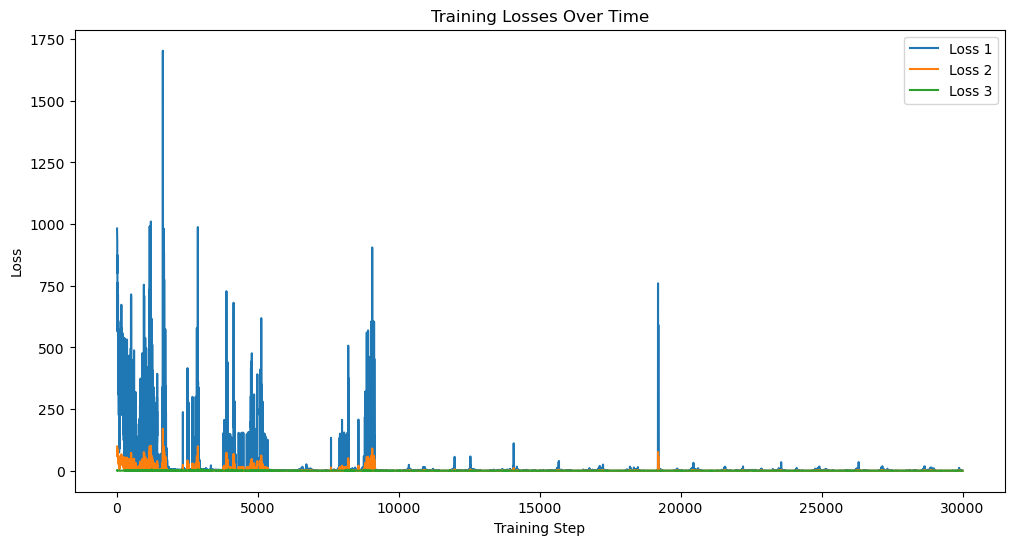

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming all_losses, all_visited, empirical_distrib_losses are lists of lists or arrays

# Plot the losses
if all_losses:
    all_losses_array = np.array(all_losses)
    plt.figure(figsize=(12, 6))
    for i in range(all_losses_array.shape[1]):
        plt.plot(all_losses_array[:, i], label=f'Loss {i+1}')
    plt.xlabel('Training Step')
    plt.ylabel('Loss')
    plt.title('Training Losses Over Time')
    plt.legend()
    plt.show()


In [63]:
# Sort visited states by reward in descending order
visited_sorted_by_reward = sorted(all_visited_done, key=lambda x: x[1], reverse=True)

# Sample the top 10 states with the highest rewards
top_states = visited_sorted_by_reward[:20]

print("Top 10 States with Highest Rewards:")
for i, (state, reward) in enumerate(top_states):
    print(f"State {i+1}: {state}, Reward: {reward}")


Top 10 States with Highest Rewards:
State 1: (11, 1, 10, 1, 0, 0, 1, 6, 0, 1, 1, 1, 2, 0, 1, 1, 2, 0, 0, 1, 1, 2, 2, 0, 0), Reward: 300000000000000000
State 2: (11, 0, 5, 0, 0, 1, 4, 1, 0, 2, 2, 4, 1, 1, 6, 2, 1, 1, 1, 2, 3, 1, 0, 1, 6), Reward: 3000000000000
State 3: (11, 0, 4, 1, 1, 1, 4, 1, 0, 3, 0, 0, 1, 0, 4, 1, 2, 1, 0, 1, 4, 0, 0, 1, 1), Reward: 3000000
State 4: (11, 0, 5, 1, 0, 0, 4, 0, 2, 2, 1, 0, 0, 5, 0, 0, 1, 1, 0, 1, 1, 3, 2, 0, 7), Reward: 300000
State 5: (11, 0, 4, 1, 0, 0, 1, 5, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1), Reward: 30000
State 6: (11, 0, 4, 0, 1, 0, 4, 2, 0, 1, 0, 0, 2, 1, 1, 0, 0, 0, 0, 2, 0, 0, 1, 0, 1), Reward: 30000
State 7: (9, 0, 11, 0, 1, 1, 1, 5, 0, 2, 2, 2, 2, 0, 0, 0, 1, 0, 0, 6, 5, 0, 0, 0, 2), Reward: 30000
State 8: (7, 0, 11, 0, 0, 1, 2, 6, 0, 4, 0, 4, 2, 1, 2, 3, 6, 1, 0, 2, 1, 2, 1, 0, 3), Reward: 30000
State 9: (8, 1, 11, 0, 0, 0, 2, 5, 3, 2, 2, 1, 3, 2, 1, 2, 0, 0, 0, 2, 0, 0, 0, 1, 0), Reward: 30000
State 10: (11, 0, 4, 2, 1, 0, 

In [64]:
import pickle
import gzip
import os

args = Args()

env = GridEnv(args.horizon, args.ndim, func=f)

agent_path = "/home/dannyhuang/gflownet/frontline/results-v3/7-node/agent_checkpoint_30000.pkl.gz"
print(agent_path)

# Load the trained_agent object from the file
try:
    with gzip.open(agent_path, 'rb') as f:
        trained_agent = pickle.load(f)
    print(trained_agent)
except FileNotFoundError:
    print(f"Error: The file {agent_path} was not found.")
except Exception as e:
    print(f"An error occurred while loading the file: {str(e)}")

/home/dannyhuang/gflownet/frontline/results-v3/7-node/agent_checkpoint_30000.pkl.gz


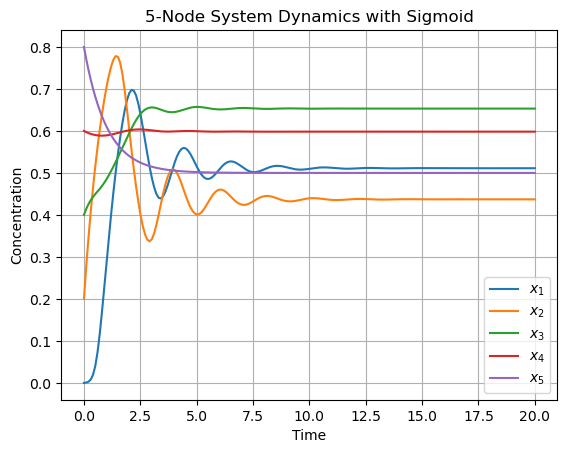

Reward: 12


In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import ipywidgets as widgets
from ipywidgets import interact

delta = 0.0001

# Define the sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Define the dynamical system for the n-node system with sigmoid
def n_node_system_with_sigmoid(x, t, *weights):
    nnode = int(np.sqrt(len(weights)))
    M_tilde = np.array(weights).reshape((nnode, nnode))
    
    # Compute M_tilde * x
    z = M_tilde.dot(x)
    
    # Apply sigmoid
    sigmoid_z = sigmoid(z)
    
    # Compute the derivative
    dxdt = sigmoid_z - x
    return dxdt

# Function to update plot and calculate reward
def update_plot(*weights):
    nnode = int(np.sqrt(len(weights)))
    ndim = nnode * nnode

    # Initial conditions
    x0 = np.linspace(0, 1, nnode, endpoint=False)

    # Define the time points
    t = np.linspace(0, 20, 200)

    # Solve ODE
    sol = odeint(n_node_system_with_sigmoid, x0, t, args=tuple(weights))
    
    # Clear current plot
    plt.clf()
    
    # Plot the results
    for i in range(nnode):
        plt.plot(t, sol[:, i], label=f'$x_{i+1}$')
    plt.xlabel('Time')
    plt.ylabel('Concentration')
    plt.title(f'{nnode}-Node System Dynamics with Sigmoid')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Calculate reward based on the number of sharp peaks
    reward = calculate_reward(sol)
    print(f"Reward: {reward}")

# Function to calculate reward based on the number of sharp peaks
def calculate_reward(sol, delta=delta):
    reward = 0
    for i in range(sol.shape[1]):  # Loop through each time series x1, x2, ..., xn
        x_i = sol[:, i]
        dx_i = np.diff(x_i)  # First derivative approximation
        peaks = 0
        for j in range(1, len(dx_i)):
            if dx_i[j-1] > 0 and dx_i[j] < 0:  # Detect a peak
                sharpness = x_i[j] - (x_i[j-1] + x_i[j+1]) / 2
                if sharpness > delta:  # Check if the peak is sharp
                    peaks += 1
        reward += peaks  # Add the number of sharp peaks as reward
    return reward


# # Example usage
# nnode = 5  # Change this to set the number of nodes
# ndim = nnode * nnode
# test_weights = np.ones(ndim)
# update_plot(*test_weights)

test_state =  [11, 0, 5, 0, 0, 1, 4, 1, 0, 2, 2, 4, 1, 1, 6, 2, 1, 1, 1, 2, 3, 1, 0, 1, 6]
test_weight = env.s2x(np.int32(test_state))
update_plot(*test_weight)




In [71]:
test_weight

array([ 0.00000000e+00,  1.10000000e+01, -0.00000000e+00, -0.00000000e+00,
       -9.52627944e+00, -1.42894192e+01,  4.12500000e+00,  0.00000000e+00,
        6.18750000e+00,  3.09375000e+00,  1.54687500e+00, -4.46544349e-01,
       -3.86718750e-01, -8.20288661e-17,  5.80078125e-01,  1.67454131e-01,
        1.45019531e-01,  1.25590598e-01,  1.88385897e-01,  1.08764648e-01,
        3.32995696e-18,  0.00000000e+00,  2.88382732e-18,  4.99493545e-18,
       -1.22340634e-33])